In [3]:

%load_ext autoreload
%autoreload 2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch
from scipy.spatial.distance import cdist
import matplotlib.gridspec as gridspec
from random import sample
from scipy.ndimage import gaussian_filter1d
from matplotlib.collections import LineCollection


import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots.plots import plot_oa


import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\nlab\anaconda3\envs\ephys0\lib\site-packages\deeplabcut\__init__.py:78: UserWarning: 
        As PyTorch is not installed, unsupervised identity learning will not be available.
        Please run `pip install torch`, or ignore this warning.
        
  warnings.warn(


In [9]:
df = pd.read_hdf(r"D:\obstacle_avoidance\recordings\data_h5\G8CK_051023.h5")

In [5]:
import math

def calculate_speed(x_positions, y_positions, time_interval):
    speeds = []
    
    # Check if the number of positions is the same for x and y
    if len(x_positions) != len(y_positions):
        raise ValueError("The number of x and y positions must be the same.")
    
    # Iterate over the positions
    for i in range(1, len(x_positions)):
        # Calculate the change in x and y positions
        delta_x = x_positions[i] - x_positions[i-1]
        delta_y = y_positions[i] - y_positions[i-1]
        
        # Calculate the distance using Pythagorean theorem
        distance = math.sqrt(delta_x**2 + delta_y**2)
        
        # Calculate the speed by dividing distance by time
        speed = distance / time_interval
        
        speeds.append(speed)
    
    return np.array(speeds)

def plot_single_trial(df,ax,cluster):
    plot_arena(df,ax)
    plot_orginal_obstacle(df,ax,cluster)
    ax.plot(df['ts_nose_x_cm'].item(),df['ts_nose_y_cm'].item())
def get_angle_to_ports(df):

    for ind,row in df.iterrows():
        angle_to_rightport = []
        angle_to_leftport = []
        rightport = [row['rightportT_x_cm'],row['rightportT_y_cm']]
        leftport = [row['leftportT_x_cm'],row['leftportT_y_cm']]
        for indx in range(len(row['ts_nose_x_cm'])):
            center = [np.mean([row['ts_rightear_x_cm'][indx],row['ts_leftear_x_cm'][indx]]),np.mean([row['ts_rightear_y_cm'][indx],row['ts_leftear_y_cm'][indx]])]
            nose_points = [row['ts_nose_x_cm'][indx],row['ts_nose_y_cm'][indx]]
            angleright = calculate_angle(center, nose_points, rightport)
            angleleft = calculate_angle(center, nose_points, leftport)
            angle_to_rightport.append(angleright)
            angle_to_leftport.append(angleleft)
        df.at[ind,'angle_to_rightport'] = np.array(angle_to_rightport).astype(object)
        df.at[ind,'angle_to_leftport'] = np.array(angle_to_leftport).astype(object)
    right_left = ['angle_to_leftport','angle_to_rightport','ts_nose_x_cm','ts_nose_y_cm']
    for ind,row in df.iterrows():
        for direction in right_left:
            interp = pd.Series(row[direction].astype(float)).interpolate().values
            resample = signal.resample(interp,200)
            df.at[ind,'resample_'+ direction] = resample.astype(object)

def angle_to_edges(df):
    keys = list_columns(df,['obstacle'])
    keys = [key for key in keys if 'gt' in key if 'mean' not in key and 'cen' not in key and 'cm' in key] 
    corner_list = []
    for corner in keys:
        corner = corner.split('_',2)[1]
        corner_list.append(corner)
    np.unique(corner_list).tolist()
    for ind,row in df.iterrows():
        for corner in corner_list:
            angle_to = []
            position = [row['gt_' + corner + '_x_cm'],row['gt_' + corner + '_y_cm']]
            for indx in range(len(row['ts_nose_x_cm'])):
                center = [np.mean([row['ts_rightear_x_cm'][indx],row['ts_leftear_x_cm'][indx]]),np.mean([row['ts_rightear_y_cm'][indx],row['ts_leftear_y_cm'][indx]])]
                nose_points = [row['ts_nose_x_cm'][indx],row['ts_nose_y_cm'][indx]]
                angle = calculate_angle(center, nose_points, position)
                angle_to.append(angle)

            df.at[ind,'angle_to_' + corner] = np.array(angle_to).astype(object)
def speed(df):
    time = float(1/60)
    for ind, row in df.iterrows():
        speed = calculate_speed(row['ts_nose_x_cm'],row['ts_nose_y_cm'],time)
        df.at[ind,'speed'] = speed.astype(object)


In [6]:
df

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,leftear_x,leftear_y,rightear_x,...,mean_gt_obstacleTR_y_cm,mean_gt_obstacleBR_x_cm,mean_gt_obstacleBR_y_cm,mean_gt_obstacleBL_x_cm,mean_gt_obstacleBL_y_cm,interp_ts_nose_x_cm,interp_ts_nose_y_cm,start,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
0,1,55849.980608,55854.351193,"[55849.982899, 55850.000243, 55850.016243, 558...","[[618, 619, 620, 621, 622, 623, 624, 625, 626,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[678.4732055664062, 678.5654907226562, 679.592...","[263.2254638671875, 264.38568115234375, 265.22...","[670.2373046875, 670.263916015625, 670.7482910...",...,14.651349,37.275039,28.448987,32.296357,28.589656,"[47.57991702286641, 46.40804070112227, 44.5507...","[22.11995199212882, 22.252543680520972, 22.658...",bottom,"[48.83511684877562, 48.57885070406783, 48.1475...","[24.610441352517263, 24.69590947377222, 24.827..."
1,3,55856.703040,55863.809664,"[55856.718592, 55856.735385, 55856.752588, 558...","[[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[681.59326171875, 682.0374755859375, 682.17260...","[261.0768127441406, 261.3218078613281, 261.290...","[671.5408325195312, 672.2661743164062, 672.129...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[49.12324392091654, 48.80135954969257, 48.1626...","[24.1267370906493, 24.75601866229086, 25.55811...",bottom,"[48.523718399309814, 48.25105688854951, 47.771...","[24.839330558971344, 24.873612257996918, 24.93..."
2,5,55873.899059,55878.777804,"[55873.907904, 55873.92471, 55873.941286, 5587...","[[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[676.9694213867188, 677.7153930664062, 678.769...","[262.11907958984375, 262.3038330078125, 263.46...","[670.2584838867188, 671.1596069335938, 672.537...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[48.589135174692714, 48.5113897534193, 48.3638...","[20.726043231174923, 20.627032772088857, 20.43...",top,"[47.23085389518286, 47.02362270959331, 46.6406...","[17.061126809811416, 17.074019096720626, 17.10..."
3,7,55884.844595,55888.674624,"[55884.845299, 55884.861926, 55884.879436, 558...","[[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[677.1893310546875, 678.1749877929688, 679.715...","[259.8717346191406, 261.8793640136719, 263.211...","[668.1810302734375, 669.8963623046875, 671.902...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[49.43852030968185, 49.33399554202782, 49.1111...","[25.275596782850933, 25.47849633090585, 25.829...",bottom,"[48.854616926116755, 48.58771892493375, 48.122...","[25.27121415192697, 25.36083638269888, 25.5059..."
4,8,55888.674624,55892.103206,"[55888.68014, 55888.696358, 55888.713036, 5588...","[2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...","[98.96044158935547, 98.02863311767578, 98.9829...","[278.30615234375, 278.5882568359375, 278.59121...","[117.44532012939453, 116.13001251220703, 115.6...","[265.80596923828125, 266.5619812011719, 267.55...","[106.43080139160156, 104.86589813232422, 104.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.743467536269417, 10.8739067033673, 11.1052...","[21.754542231262036, 21.73326920385291, 21.671...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.29648127572867, 18.197700082746092, 18.029..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,158,56997.887680,56999.653209,"[56997.904038, 56997.920294, 56997.936742, 569...","[[36468, 36469, 36470, 36471, 36472, 36473, 36...","[684.3792724609375, nan, nan, nan, nan, nan, n...","[275.2332458496094, nan, nan, nan, nan, nan, n...","[671.2802734375, 671.4435424804

In [ ]:
fake_time = np.linspace(0,1,50)
for ind, row in df.iterrows():
    xT = np.linspace(0,1,len(row['ts_nose_x_cm']))
    intx = interp1d(xT, row['ts_nose_x_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
    df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)


In [21]:
"""calculate the nose x interp
interp nose x is interpolation across the same time basis of 50 bins"""
fake_time = np.linspace(0,1,50)
for ind, row in df.iterrows():
    xT = np.linspace(0,1,len(row['ts_nose_x_cm']))
    yT = np.linspace(0,1,len(row['ts_nose_y_cm']))
    intx = interp1d(xT, row['ts_nose_x_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
    inty = interp1d(yT, row['ts_nose_y_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
    
    df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)
    df.at[ind,'interp_ts_nose_y_cm'] = inty.astype(object)

In [23]:
"""labe top or bottom start"""
labels = ['top','bottom']
top_bottom = split_range_into_parts(pd.unique(df.arenaTL_y_cm).item(),pd.unique(df.arenaBL_y_cm).item(),2)
top_bottom_dict = dict(zip(labels,top_bottom))
for ind, row in df.iterrows():
    if top_bottom_dict.get('top')[0]<= np.nanmean(row['interp_ts_nose_y_cm'][:5]) <= top_bottom_dict.get('top')[1]:
        df.at[ind,'1start'] = 'top'
    if top_bottom_dict.get('bottom')[0]<= np.nanmean(row['interp_ts_nose_y_cm'][:5]) <= top_bottom_dict.get('bottom')[1]:
        df.at[ind,'1start'] = 'bottom'
    if np.nanmean(row['interp_ts_nose_y_cm'][:5]) == np.nan:
       df.drop(df.iloc[ind])

In [13]:

"""calculate the nose x interp
interp nose x is interpolation across the same time basis of 50 bins"""
fake_time = np.linspace(0,1,50)
for ind, row in df.iterrows():
    xT = np.linspace(0,1,len(row['ts_nose_x_cm']))
    intx = interp1d(xT, row['ts_nose_x_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
    df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)
    
"""get the average of nose x given the same start, obstalce and direction"""
for direction, direction_frame in df.groupby(['odd']):
    for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
        for start, start_frame in cluster_frame.groupby(['start']):
            array = np.zeros([len(start_frame), 50])
            count = 0
            for ind,row in start_frame.iterrows():
                array[count,:] = row['interp_ts_nose_x_cm']
                count += 1
            mean_trace = np.nanmean(array,axis = 0)
            x = df.loc[(df['obstacle_cluster'] ==cluster) & (df['start']==start)&(df['odd'] ==direction)]
            for ind,row in x.iterrows():
                df.at[ind,'mean_interp_ts_nose_x_cm']= mean_trace.astype(object)
            #df = df[df['mean_interp_ts_nose_x_cm'].notna()]
print(df['mean_interp_ts_nose_x_cm'].isna().sum())


2


In [77]:
df[df['mean_interp_ts_nose_x_cm'].notna()]

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,leftear_x,leftear_y,rightear_x,...,mean_gt_obstacleTR_y_cm,mean_gt_obstacleBR_x_cm,mean_gt_obstacleBR_y_cm,mean_gt_obstacleBL_x_cm,mean_gt_obstacleBL_y_cm,interp_ts_nose_x_cm,interp_ts_nose_y_cm,start,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
0,1,55849.980608,55854.351193,"[55849.982899, 55850.000243, 55850.016243, 558...","[[618, 619, 620, 621, 622, 623, 624, 625, 626,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[678.4732055664062, 678.5654907226562, 679.592...","[263.2254638671875, 264.38568115234375, 265.22...","[670.2373046875, 670.263916015625, 670.7482910...",...,14.651349,37.275039,28.448987,32.296357,28.589656,"[47.57991702286641, 46.40804070112227, 44.5507...","[22.02954763565726, 22.0480049166571, 22.07906...",bottom,"[48.83511684877562, 48.57885070406783, 48.1475...","[24.494542994333457, 24.6048723531612, 24.7847..."
1,3,55856.703040,55863.809664,"[55856.718592, 55856.735385, 55856.752588, 558...","[[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[681.59326171875, 682.0374755859375, 682.17260...","[261.0768127441406, 261.3218078613281, 261.290...","[671.5408325195312, 672.2661743164062, 672.129...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[49.12324392091654, 48.80135954969257, 48.1626...","[25.187015648050334, 25.500873349709863, 25.47...",bottom,"[48.523718399309814, 48.25105688854951, 47.771...","[24.60045923488046, 24.70616638827171, 24.8189..."
2,5,55873.899059,55878.777804,"[55873.907904, 55873.92471, 55873.941286, 5587...","[[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[676.9694213867188, 677.7153930664062, 678.769...","[262.11907958984375, 262.3038330078125, 263.46...","[670.2584838867188, 671.1596069335938, 672.537...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[48.589135174692714, 48.5113897534193, 48.3638...","[19.146326805992928, 18.967624013101506, 18.66...",top,"[47.23085389518286, 47.02362270959331, 46.6406...","[17.061126809811416, 17.074019096720626, 17.10..."
3,7,55884.844595,55888.674624,"[55884.845299, 55884.861926, 55884.879436, 558...","[[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[677.1893310546875, 678.1749877929688, 679.715...","[259.8717346191406, 261.8793640136719, 263.211...","[668.1810302734375, 669.8963623046875, 671.902...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[49.43852030968185, 49.33399554202782, 49.1111...","[26.101575847543554, 26.24708392544514, 26.297...",bottom,"[48.854616926116755, 48.58771892493375, 48.122...","[25.27121415192697, 25.36083638269888, 25.5059..."
4,8,55888.674624,55892.103206,"[55888.68014, 55888.696358, 55888.713036, 5588...","[2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...","[98.96044158935547, 98.02863311767578, 98.9829...","[278.30615234375, 278.5882568359375, 278.59121...","[117.44532012939453, 116.13001251220703, 115.6...","[265.80596923828125, 266.5619812011719, 267.55...","[106.43080139160156, 104.86589813232422, 104.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.743467536269417, 10.8739067033673, 11.1052...","[16.280032718224625, 15.069797288170353, 14.17...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.129593080368032, 18.047704796064398, 17.88..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,158,56997.887680,56999.653209,"[56997.904038, 56997.920294, 56997.936742, 569...","[[36468, 36469, 36470, 36471, 36472, 36473, 36...","[684.3792724609375, nan, nan, nan, nan, nan, n...","[275.2332458496094, nan, nan, nan, nan, nan, n...","[671.2802734375, 671.4435424804

In [74]:

"""Calculate interp y which is interpolation of nose_x vs nose_y then ploted against the mean_interp_noseX """
for ind,row in df.iterrows():
    
    interp = interp1d(row['ts_nose_x_cm'].astype(float), row['ts_nose_y_cm'].astype(float) ,bounds_error=False, fill_value="extrapolate")
    interp_y = interp(row['mean_interp_ts_nose_x_cm'].astype(float))
    interp_y = interpolate_array(interp_y)
    df.at[ind,'interp_ts_nose_y_cm'] = interp_y.astype(object)

for direction, direction_frame in df.groupby(['odd']):
    for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
        for start, start_frame in cluster_frame.groupby(['start']):
            array = np.zeros([len(start_frame), 50])
            count = 0
            for ind,row in start_frame.iterrows():
                array[count,:] = row['interp_ts_nose_y_cm']
                count += 1
            mean_trace = np.nanmean(array,axis=0)
            median_trace = np.nanmedian(array,axis = 0)
            x = df.loc[(df['obstacle_cluster'] ==cluster) & (df['start']==start)&(df['odd'] ==direction)]
            for ind,row in x.iterrows():
                if cluster in [2,3]:
                    df.at[ind,'mean_interp_ts_nose_y_cm']= median_trace.astype(object)
                else:
                    df.at[ind,'mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
    
             







AttributeError: 'float' object has no attribute 'astype'

In [76]:
row['mean_interp_ts_nose_x_cm']

nan

In [89]:
def interp_plot(df,key,color_pallete,num_sample):

    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)

   

    fig = plt.figure(constrained_layout=False, figsize=(15, 15),dpi=90)
    fig.suptitle('by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)


    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)

    ax3 = fig.add_subplot(panel_1[0,2])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[1,2])
    plot_arena(df,ax6)

    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')


    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[0,2])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[1,2])
    plot_arena(df,ax12)

    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')



    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))

    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstacle_axis = left_obstacle_dict.get(cluster)
            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstacle_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstacle_axis.set_title(str(cluster))
            for ind,row in cluster_frame.iterrows():
                    color = color_map.get(pd.unique(str(row[key])).item())
                    if direction == 'right':
                        which_axis = right_obstacle_dict.get(cluster)
                        which_axis.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = color,alpha = .5)

                    if direction == 'left':
                        which_axis = left_obstacle_dict.get(cluster)
                        which_axis.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = color,alpha = .5)
            for start, start_frame in cluster_frame.groupby(['start']):
                
                if direction == 'right':
                    if start == 'top':
                        right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                        right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                    if start == 'bottom':
                        right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')

                
                if direction == 'left':
                    if start == 'top':
                        left_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                    if start == 'bottom':
                        left_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')

In [81]:
session = plot_oa(r"D:\obstacle_avoidance\metadata\G8CK\G8CK_oa_042823_050323.json",'blank')
session.gather_session_df('obstacle',6)

6
4576
4574


In [82]:
session.df

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,leftear_x,leftear_y,rightear_x,...,mean_gt_obstacleTR_y_cm,mean_gt_obstacleBR_x_cm,mean_gt_obstacleBR_y_cm,mean_gt_obstacleBL_x_cm,mean_gt_obstacleBL_y_cm,interp_ts_nose_x_cm,interp_ts_nose_y_cm,start,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
0,1,55849.980608,55854.351193,"[55849.982899, 55850.000243, 55850.016243, 558...","[[618, 619, 620, 621, 622, 623, 624, 625, 626,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[678.4732055664062, 678.5654907226562, 679.592...","[263.2254638671875, 264.38568115234375, 265.22...","[670.2373046875, 670.263916015625, 670.7482910...",...,14.651349,37.275039,28.448987,32.296357,28.589656,"[47.57991702286641, 46.40804070112227, 44.5507...","[22.02954763565726, 22.0480049166571, 22.07906...",bottom,"[48.83511684877562, 48.57885070406783, 48.1475...","[24.74558186736711, 24.822061532380186, 24.915..."
1,3,55856.703040,55863.809664,"[55856.718592, 55856.735385, 55856.752588, 558...","[[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[681.59326171875, 682.0374755859375, 682.17260...","[261.0768127441406, 261.3218078613281, 261.290...","[671.5408325195312, 672.2661743164062, 672.129...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[49.12324392091654, 48.80135954969257, 48.1626...","[25.187015648050334, 25.500873349709863, 25.47...",bottom,"[48.523718399309814, 48.25105688854951, 47.771...","[24.829744179438276, 24.870757697301773, 24.91..."
2,5,55873.899059,55878.777804,"[55873.907904, 55873.92471, 55873.941286, 5587...","[[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[676.9694213867188, 677.7153930664062, 678.769...","[262.11907958984375, 262.3038330078125, 263.46...","[670.2584838867188, 671.1596069335938, 672.537...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[48.589135174692714, 48.5113897534193, 48.3638...","[19.146326805992928, 18.967624013101506, 18.66...",top,"[47.23085389518286, 47.02362270959331, 46.6406...","[17.345791485123073, 17.368285326545962, 17.39..."
3,7,55884.844595,55888.674624,"[55884.845299, 55884.861926, 55884.879436, 558...","[[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[677.1893310546875, 678.1749877929688, 679.715...","[259.8717346191406, 261.8793640136719, 263.211...","[668.1810302734375, 669.8963623046875, 671.902...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[49.43852030968185, 49.33399554202782, 49.1111...","[26.101575847543554, 26.24708392544514, 26.297...",bottom,"[48.854616926116755, 48.58771892493375, 48.122...","[25.374360596087406, 25.427639804123896, 25.49..."
4,8,55888.674624,55892.103206,"[55888.68014, 55888.696358, 55888.713036, 5588...","[2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...","[98.96044158935547, 98.02863311767578, 98.9829...","[278.30615234375, 278.5882568359375, 278.59121...","[117.44532012939453, 116.13001251220703, 115.6...","[265.80596923828125, 266.5619812011719, 267.55...","[106.43080139160156, 104.86589813232422, 104.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.743467536269417, 10.8739067033673, 11.1052...","[16.280032718224625, 15.069797288170353, 14.17...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.182644566939086, 18.075931689766747, 17.87..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,158,56997.887680,56999.653209,"[56997.904038, 56997.920294, 56997.936742, 569...","[[36468, 36469, 36470, 36471, 36472, 36473, 36...","[684.3792724609375, nan, nan, nan, nan, nan, n...","[275.2332458496094, nan, nan, nan, nan, nan, n...","[671.2802734375, 671.4435424804

In [83]:
session.df.loc[(session.df['obstacle_cluster'] ==2) & (session.df['start']=='top')]

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,leftear_x,leftear_y,rightear_x,...,mean_gt_obstacleTR_y_cm,mean_gt_obstacleBR_x_cm,mean_gt_obstacleBR_y_cm,mean_gt_obstacleBL_x_cm,mean_gt_obstacleBL_y_cm,interp_ts_nose_x_cm,interp_ts_nose_y_cm,start,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
4,8,55888.674624,55892.103206,"[55888.68014, 55888.696358, 55888.713036, 5588...","[2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...","[98.96044158935547, 98.02863311767578, 98.9829...","[278.30615234375, 278.5882568359375, 278.59121...","[117.44532012939453, 116.13001251220703, 115.6...","[265.80596923828125, 266.5619812011719, 267.55...","[106.43080139160156, 104.86589813232422, 104.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.743467536269417, 10.8739067033673, 11.1052...","[16.280032718224625, 15.069797288170353, 14.17...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.182644566939086, 18.075931689766747, 17.87..."
18,26,55983.673139,55989.583910,"[55983.679833, 55983.696256, 55983.712652, 559...","[8637, 8638, 8639, 8640, 8641, 8642, 8643, 864...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[108.69401550292969, 106.77178955078125, 106.2...","[282.2787780761719, 281.28887939453125, 280.46...","[114.79920959472656, 114.25677490234375, 113.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[11.26899600561837, 11.695705578165477, 12.388...","[12.212068047584745, 12.344109304104999, 12.63...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.182644566939086, 18.075931689766747, 17.87..."
42,51,56110.725248,56114.153920,"[56110.74016, 56110.756364, 56110.773017, 5611...","[[16258, 16259, 16260, 16261, 16262, 16263, 16...","[684.6926879882812, 685.4898681640625, 685.728...","[276.6683044433594, 275.94927978515625, 275.76...","[668.5576171875, 669.5875854492188, 670.439453...","[273.0427551269531, 272.3398742675781, 272.180...","[675.8496704101562, 676.0924072265625, 677.113...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[48.17791831397504, 47.69076938311993, 46.7578...","[16.155763105751543, 16.16380047775516, 16.199...",top,"[47.27547984951218, 47.02724519082809, 46.5563...","[17.83179232395335, 17.75344317323533, 17.7475..."
43,52,56114.153920,56116.857523,"[56114.157516, 56114.174604, 56114.190886, 561...","[16463, 16464, 16465, 16466, 16467, 16468, 164...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[106.60136413574219, 105.56616973876953, 104.8...","[278.6063537597656, 278.6675109863281, 277.762...","[113.00727081298828, 111.18756103515625, 110.4...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[11.821547414238244, 12.051832798885487, 12.48...","[15.296033275794668, 15.056358403634016, 14.59...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.182644566939086, 18.075931689766747, 17.87..."
46,56,56140.718784,56145.241228,"[56140.733785, 56140.750272, 56140.767078, 561...","[18057, 18058, 18059, 18060, 18061, 18062, 180...","[100.29163360595703, 99.24923706054688, 99.574...","[276.08172607421875, 276.5611877441406, 276.11...","[119.08059692382812, 117.22584533691406, 117.4...","[265.6505126953125, 265.7574157714844, 265.639...","[109.6287841796875, 107.37015533447266, 107.38...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.538586501689966, 10.706500289814935, 10.80...","[16.00325399399447, 15.523835741322037, 14.878...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.182644566939086, 18.075931689766747, 17.87..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4473,23,56440.469350,56443.152473,"[56440.477388, 56440.495718, 56440.510784, 564...","[[3034, 3035, 3036, 3037, 3038, 3039, 3040, 30...","[682.0703125, nan, nan, nan, nan, nan, nan, na...","[273.7735290527344, nan, nan, nan, nan, nan, n...","[669.423583984375, 671.7987670898

In [67]:
session.df.loc['obstacle_cluster'] 

KeyError: 'False: boolean label can not be used without a boolean index'

In [85]:
cluster_2_start = session.df.loc[(session.df['obstacle_cluster'] ==2) & (session.df['start']=='top')]

In [88]:
for direction, direction_frame in cluster_2_start.groupby(['odd']):
    for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
        for start, start_frame in cluster_frame.groupby(['start']):
            array = np.zeros([len(start_frame), 50])
            count = 0
            for ind,row in start_frame.iterrows():
                array[count,:] = row['interp_ts_nose_y_cm']
                count += 1
            mean_trace = np.nanmean(array,axis=0)
            median_trace = np.nanmedian(array,axis = 0)
            x = cluster_2_start.loc[(cluster_2_start['obstacle_cluster'] ==cluster) & (cluster_2_start['start']==start)&(cluster_2_start['odd'] ==direction)]
            for ind,row in x.iterrows():
                if cluster in [2,3]:
                    cluster_2_start.at[ind,'median_interp_ts_nose_y_cm']= median_trace.astype(object)
                else:
                    cluster_2_start.at[ind,'mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
        

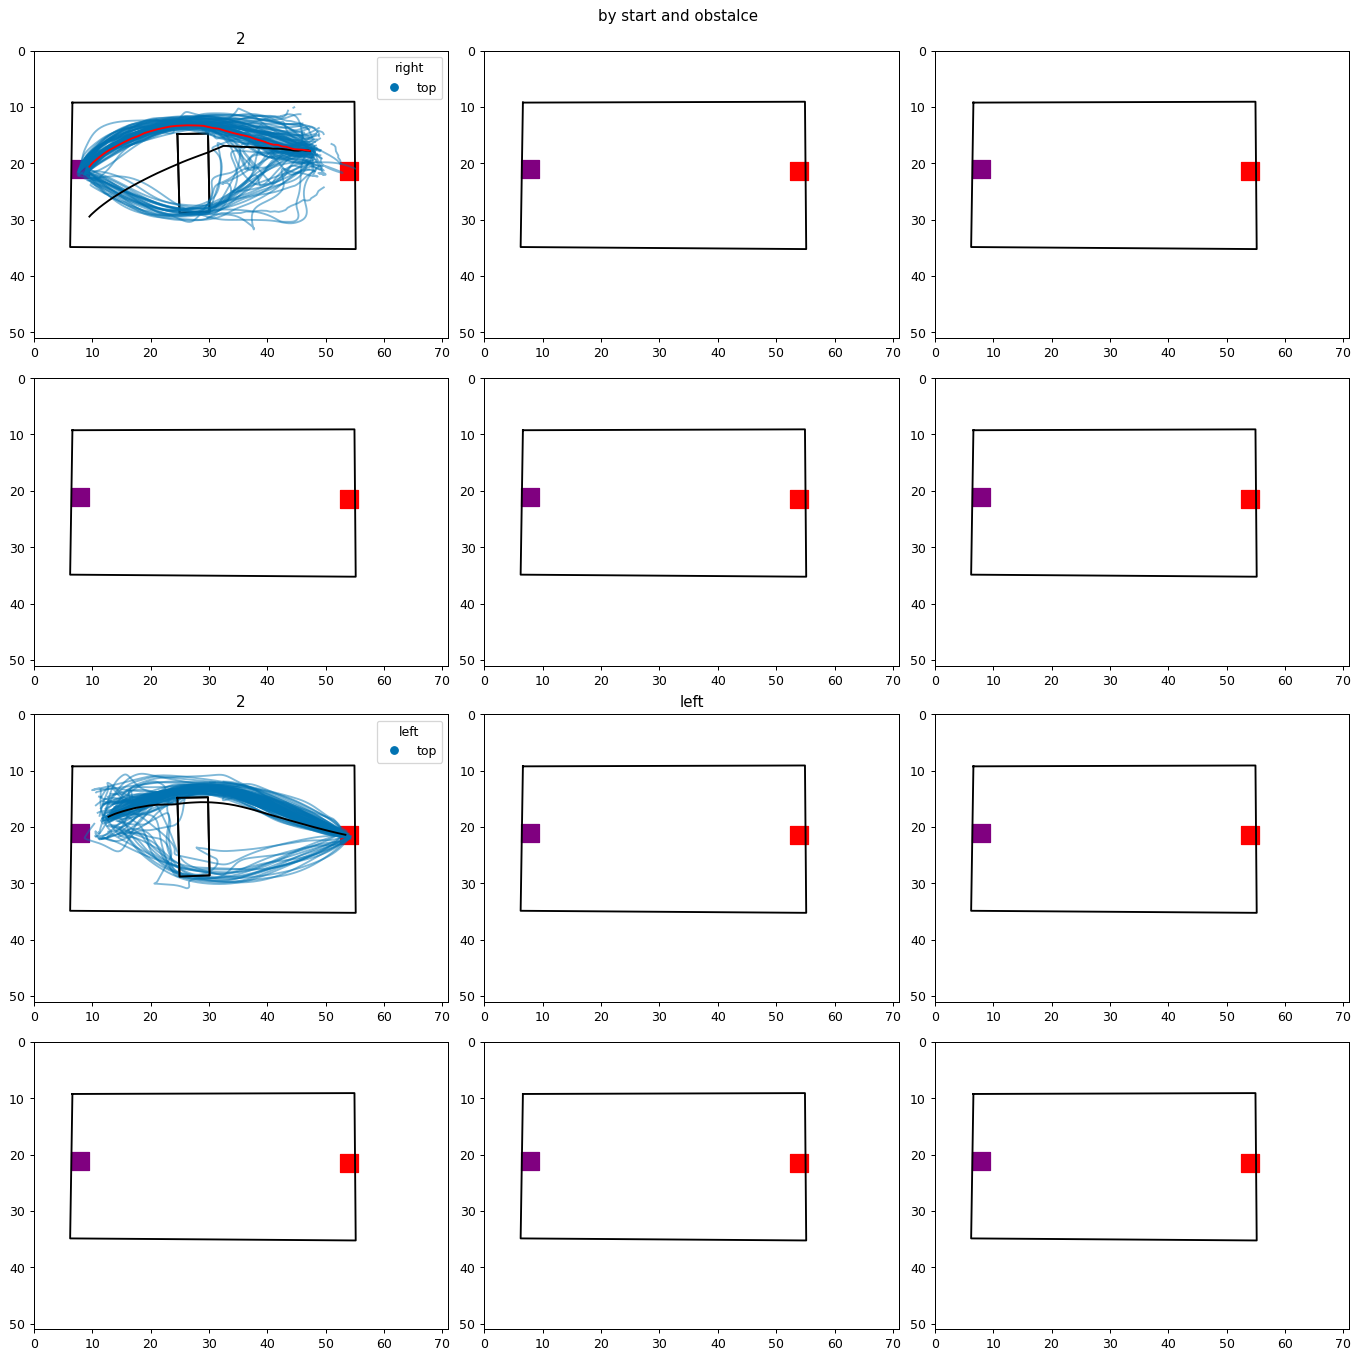

In [90]:
interp_plot(cluster_2_start,'start','colorblind',100)

In [59]:
for 

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,leftear_x,leftear_y,rightear_x,...,mean_gt_obstacleTR_y_cm,mean_gt_obstacleBR_x_cm,mean_gt_obstacleBR_y_cm,mean_gt_obstacleBL_x_cm,mean_gt_obstacleBL_y_cm,interp_ts_nose_x_cm,interp_ts_nose_y_cm,start,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
0,1,55849.980608,55854.351193,"[55849.982899, 55850.000243, 55850.016243, 558...","[[618, 619, 620, 621, 622, 623, 624, 625, 626,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[678.4732055664062, 678.5654907226562, 679.592...","[263.2254638671875, 264.38568115234375, 265.22...","[670.2373046875, 670.263916015625, 670.7482910...",...,14.651349,37.275039,28.448987,32.296357,28.589656,"[47.57991702286641, 46.40804070112227, 44.5507...","[22.11995199212882, 22.252543680520972, 22.658...",bottom,"[48.83511684877562, 48.57885070406783, 48.1475...","[24.494542994333457, 24.6048723531612, 24.7847..."
1,3,55856.703040,55863.809664,"[55856.718592, 55856.735385, 55856.752588, 558...","[[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[681.59326171875, 682.0374755859375, 682.17260...","[261.0768127441406, 261.3218078613281, 261.290...","[671.5408325195312, 672.2661743164062, 672.129...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[49.12324392091654, 48.80135954969257, 48.1626...","[24.1267370906493, 24.75601866229086, 25.55811...",bottom,"[48.523718399309814, 48.25105688854951, 47.771...","[24.60045923488046, 24.70616638827171, 24.8189..."
2,5,55873.899059,55878.777804,"[55873.907904, 55873.92471, 55873.941286, 5587...","[[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[676.9694213867188, 677.7153930664062, 678.769...","[262.11907958984375, 262.3038330078125, 263.46...","[670.2584838867188, 671.1596069335938, 672.537...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[48.589135174692714, 48.5113897534193, 48.3638...","[20.726043231174923, 20.627032772088857, 20.43...",top,"[47.23085389518286, 47.02362270959331, 46.6406...","[17.061126809811416, 17.074019096720626, 17.10..."
3,7,55884.844595,55888.674624,"[55884.845299, 55884.861926, 55884.879436, 558...","[[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[677.1893310546875, 678.1749877929688, 679.715...","[259.8717346191406, 261.8793640136719, 263.211...","[668.1810302734375, 669.8963623046875, 671.902...",...,21.124599,37.101665,34.940904,31.986852,35.028746,"[49.43852030968185, 49.33399554202782, 49.1111...","[25.275596782850933, 25.47849633090585, 25.829...",bottom,"[48.854616926116755, 48.58771892493375, 48.122...","[25.27121415192697, 25.36083638269888, 25.5059..."
4,8,55888.674624,55892.103206,"[55888.68014, 55888.696358, 55888.713036, 5588...","[2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...","[98.96044158935547, 98.02863311767578, 98.9829...","[278.30615234375, 278.5882568359375, 278.59121...","[117.44532012939453, 116.13001251220703, 115.6...","[265.80596923828125, 266.5619812011719, 267.55...","[106.43080139160156, 104.86589813232422, 104.9...",...,14.731362,30.110363,28.599506,24.966798,28.806503,"[10.743467536269417, 10.8739067033673, 11.1052...","[21.754542231262036, 21.73326920385291, 21.671...",top,"[12.796685881095609, 13.02858492826971, 13.445...","[18.129593080368032, 18.047704796064398, 17.88..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,158,56997.887680,56999.653209,"[56997.904038, 56997.920294, 56997.936742, 569...","[[36468, 36469, 36470, 36471, 36472, 36473, 36...","[684.3792724609375, nan, nan, nan, nan, nan, n...","[275.2332458496094, nan, nan, nan, nan, nan, n...","[671.2802734375, 671.4435424804

In [23]:
df.columns.to_numpy()

array(['index', 'first_poke', 'second_poke', 'trial_timestamps',
       'trial_vidframes', 'nose_x', 'nose_y', 'leftear_x', 'leftear_y',
       'rightear_x', 'rightear_y', 'spine_x', 'spine_y', 'midspine_x',
       'midspine_y', 'tailbase_x', 'tailbase_y', 'midtail_x', 'midtail_y',
       'tailend_x', 'tailend_y', 'arenaTL_x', 'arenaTL_y', 'arenaTR_x',
       'arenaTR_y', 'arenaBL_x', 'arenaBL_y', 'arenaBR_x', 'arenaBR_y',
       'obstacleTL_x', 'obstacleTL_y', 'obstacleTR_x', 'obstacleTR_y',
       'obstacleBR_x', 'obstacleBR_y', 'obstacleBL_x', 'obstacleBL_y',
       'leftportT_x', 'leftportT_y', 'leftportB_x', 'leftportB_y',
       'rightportT_x', 'rightportT_y', 'rightportB_x', 'rightportB_y',
       'len', 'animal', 'date', 'task', 'nose_x_cm', 'nose_y_cm',
       'leftear_x_cm', 'leftear_y_cm', 'rightear_x_cm', 'rightear_y_cm',
       'spine_x_cm', 'spine_y_cm', 'midspine_x_cm', 'midspine_y_cm',
       'tailbase_x_cm', 'tailbase_y_cm', 'midtail_x_cm', 'midtail_y_cm',
       'tail

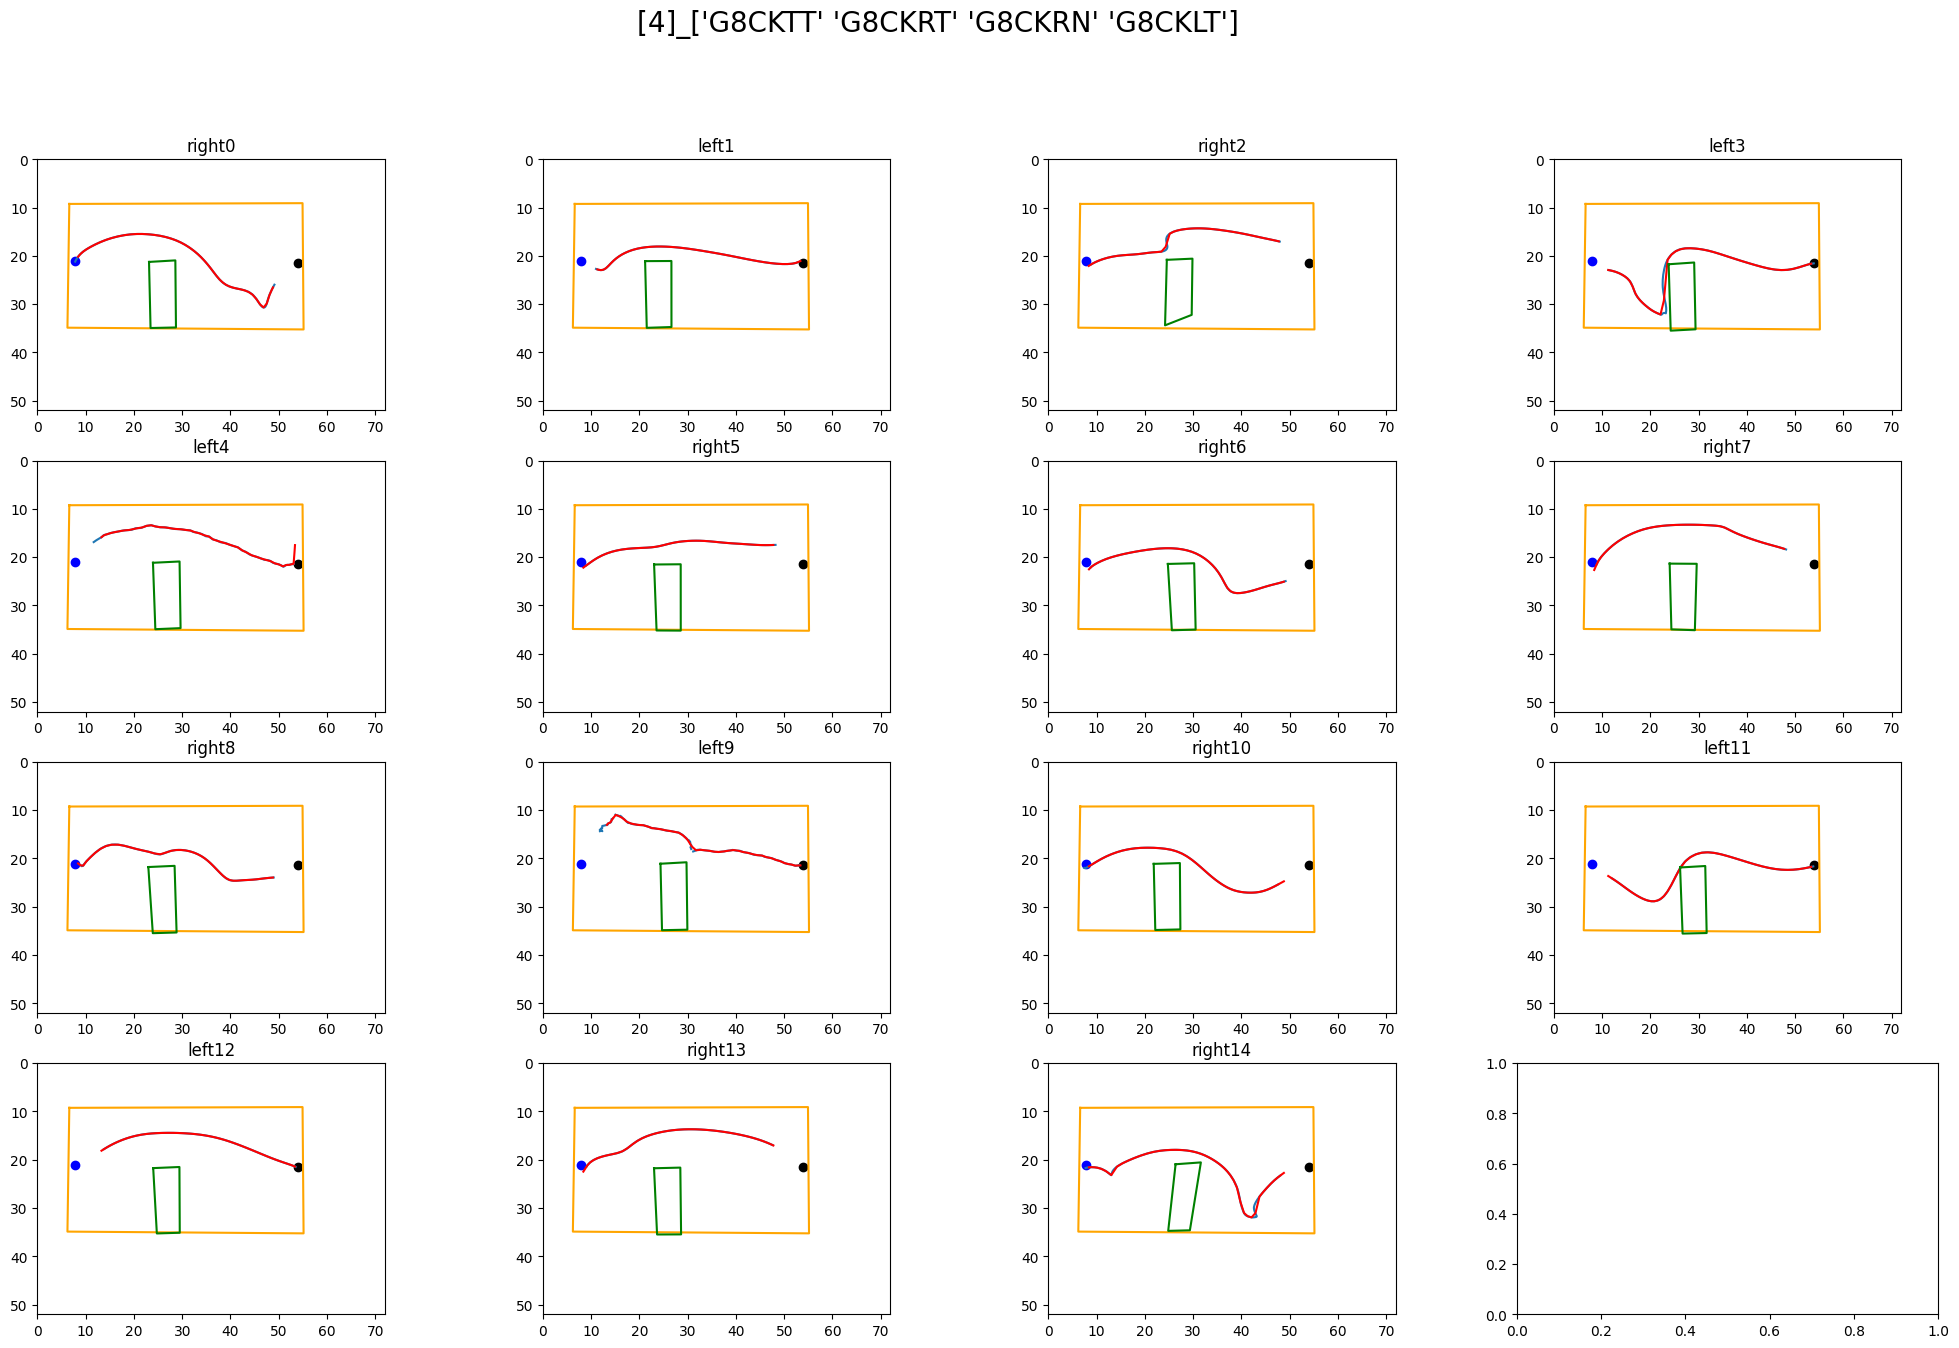

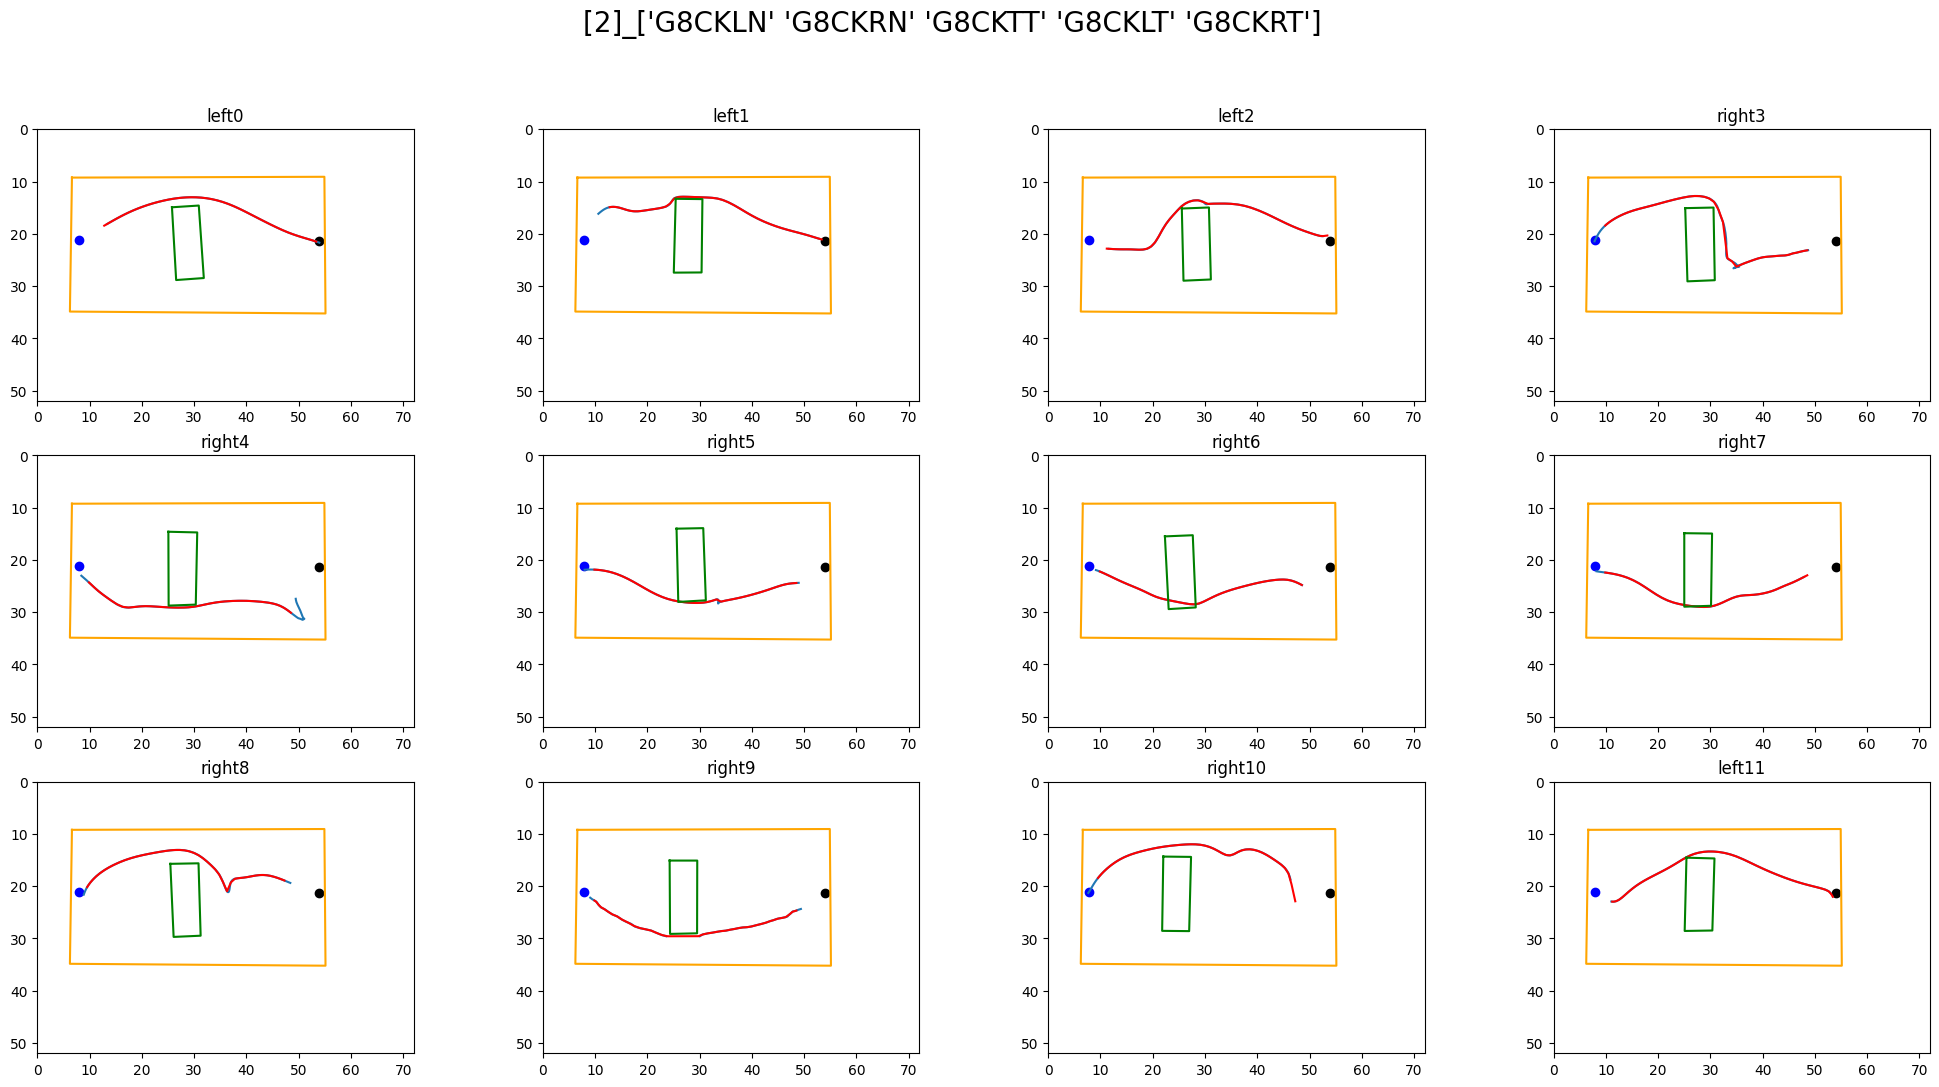

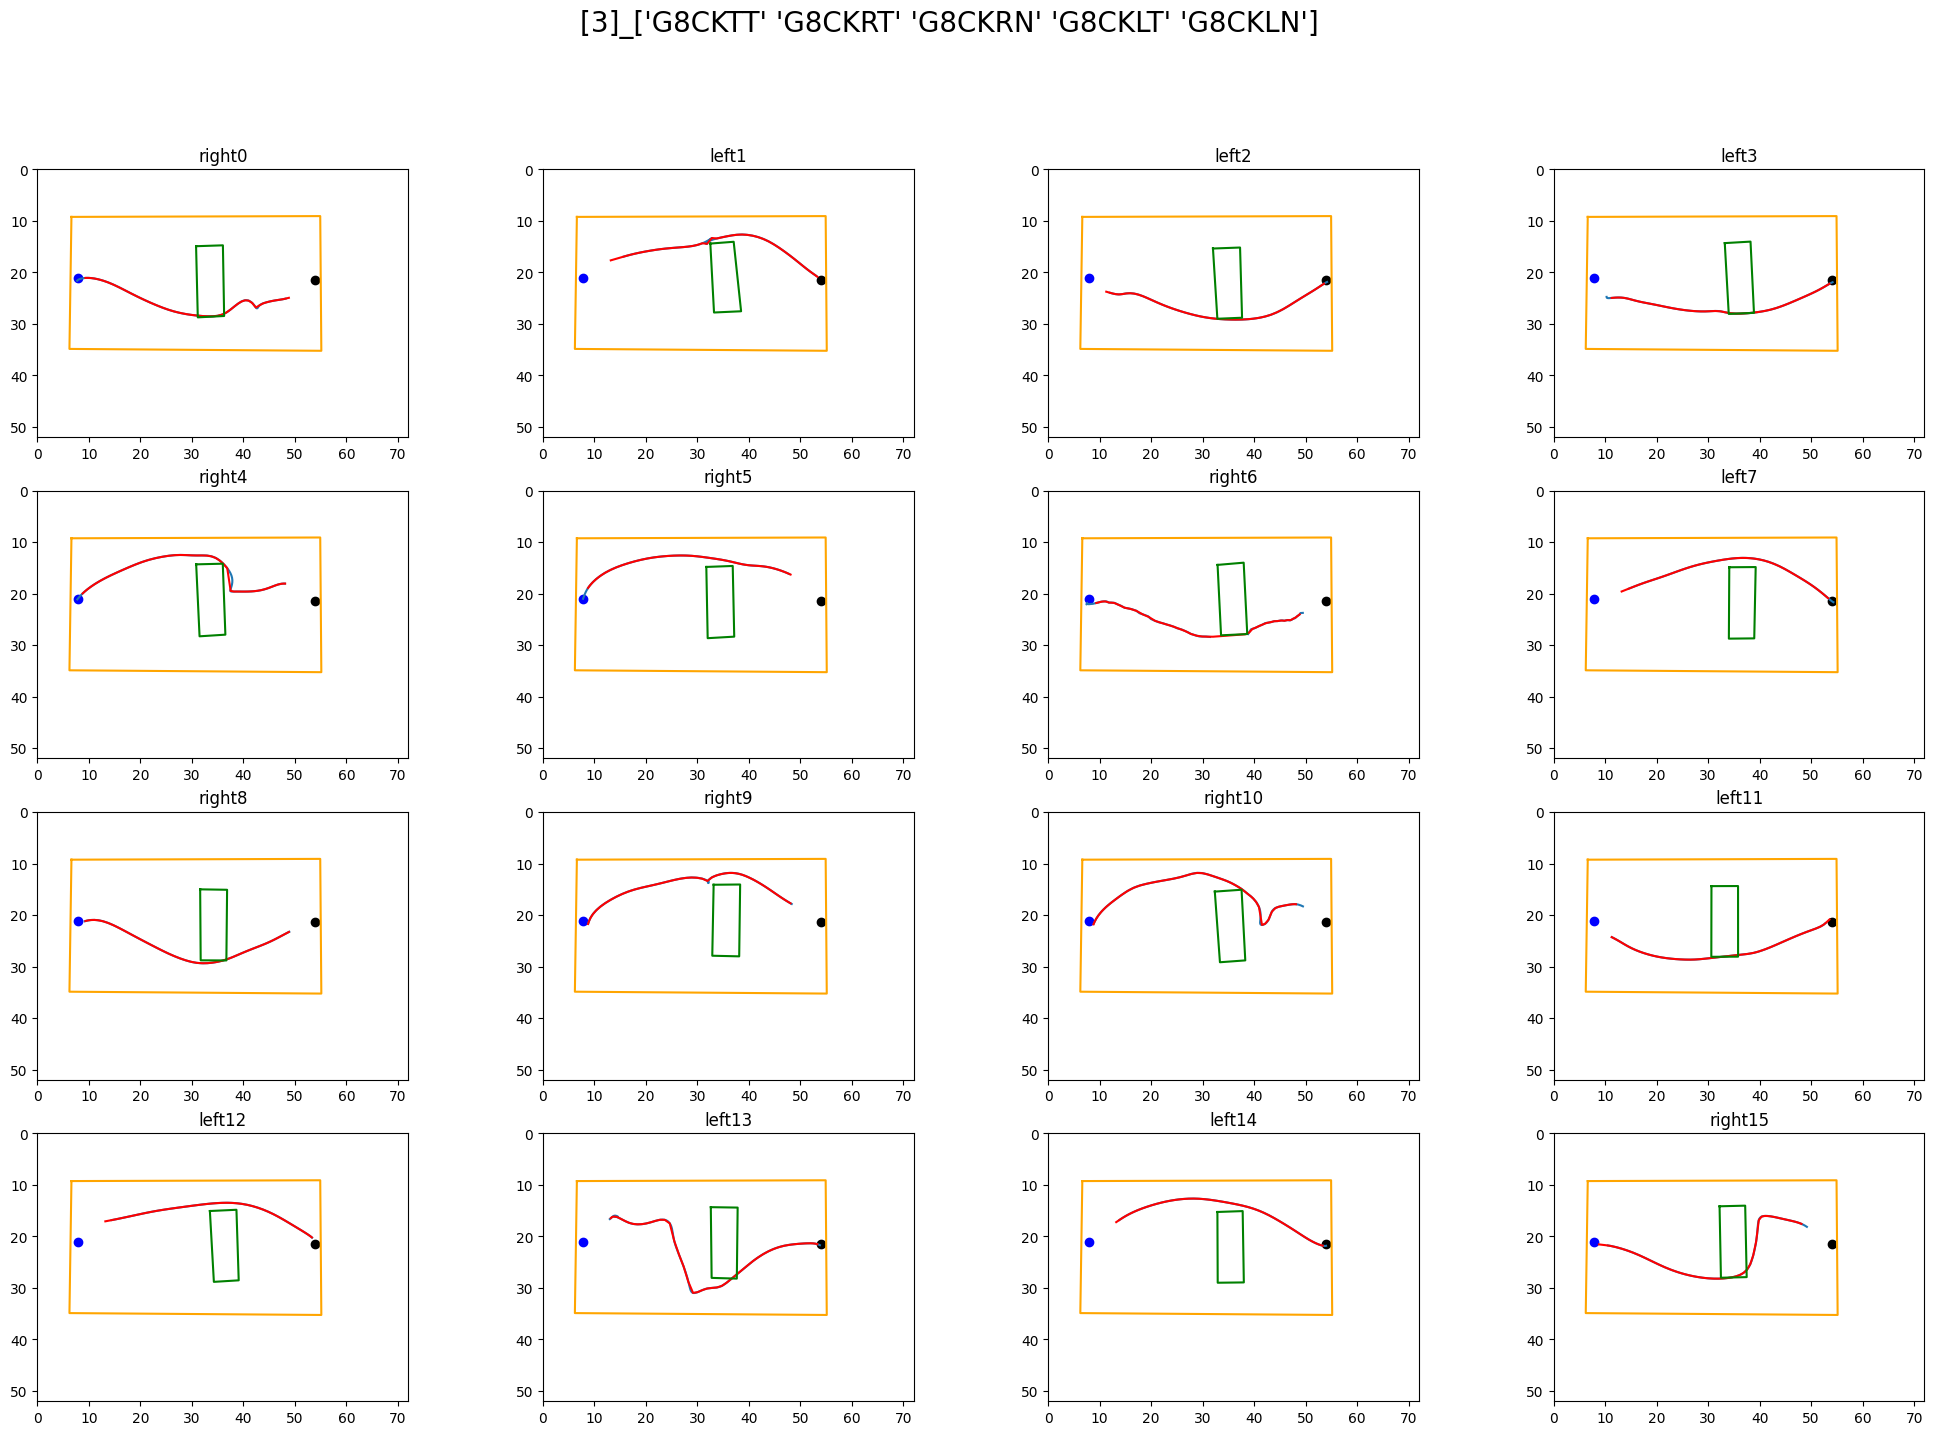

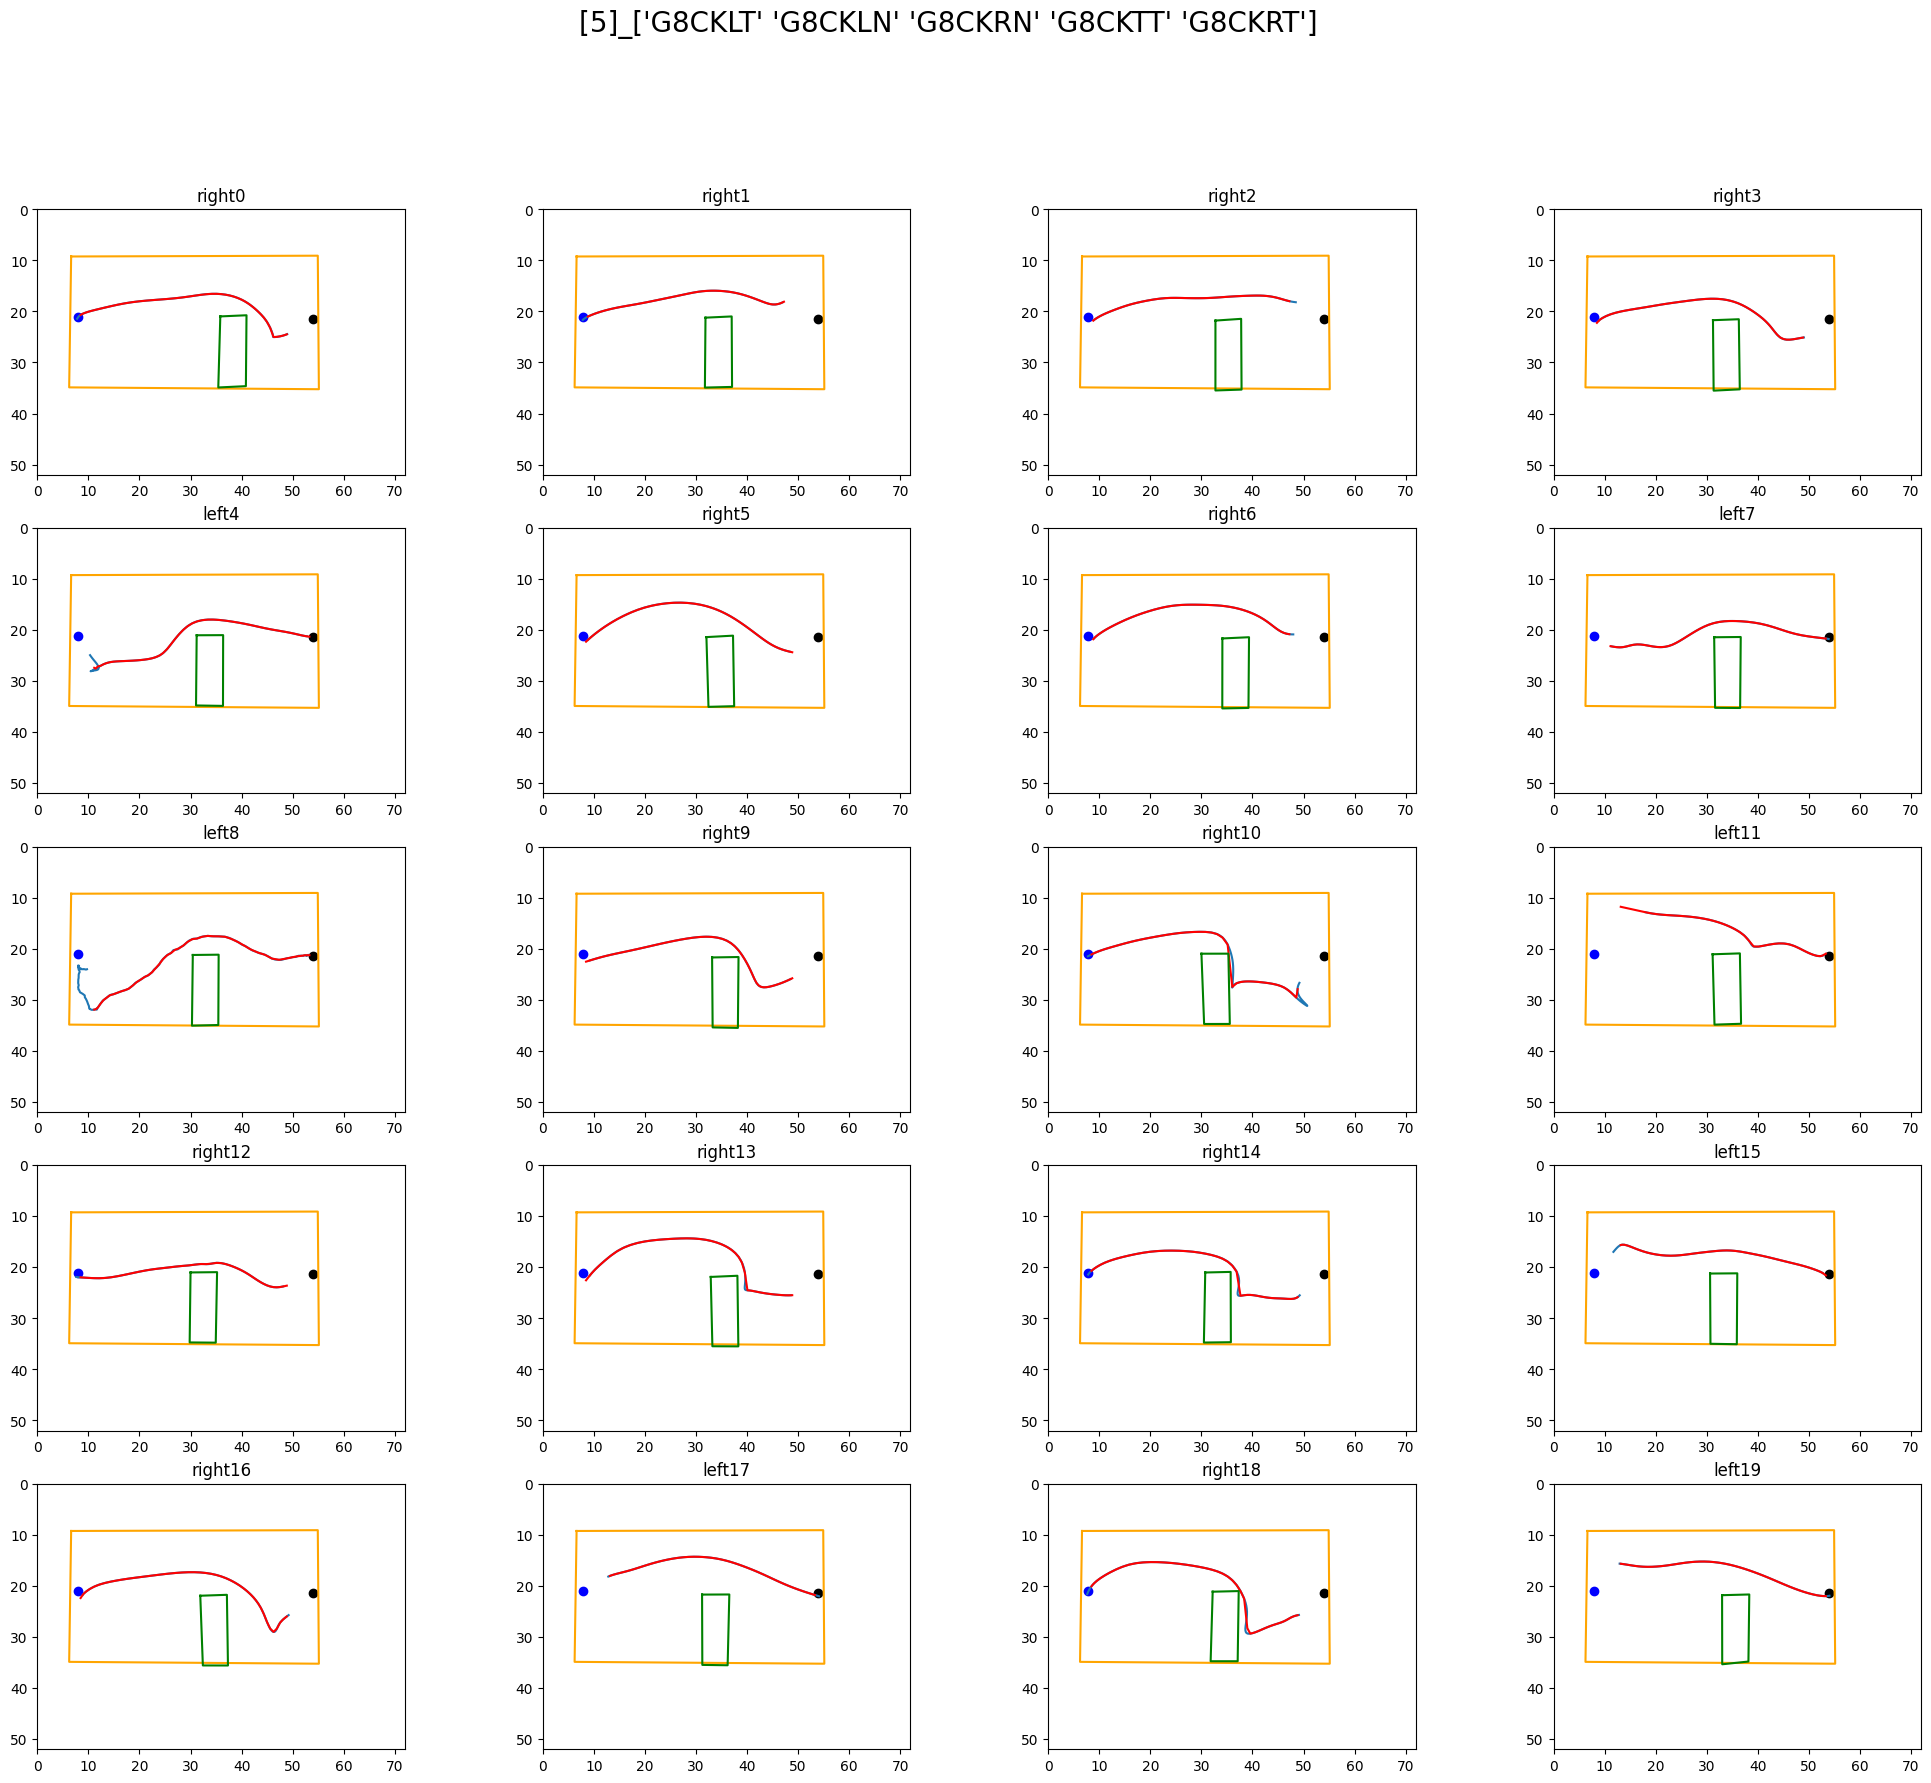

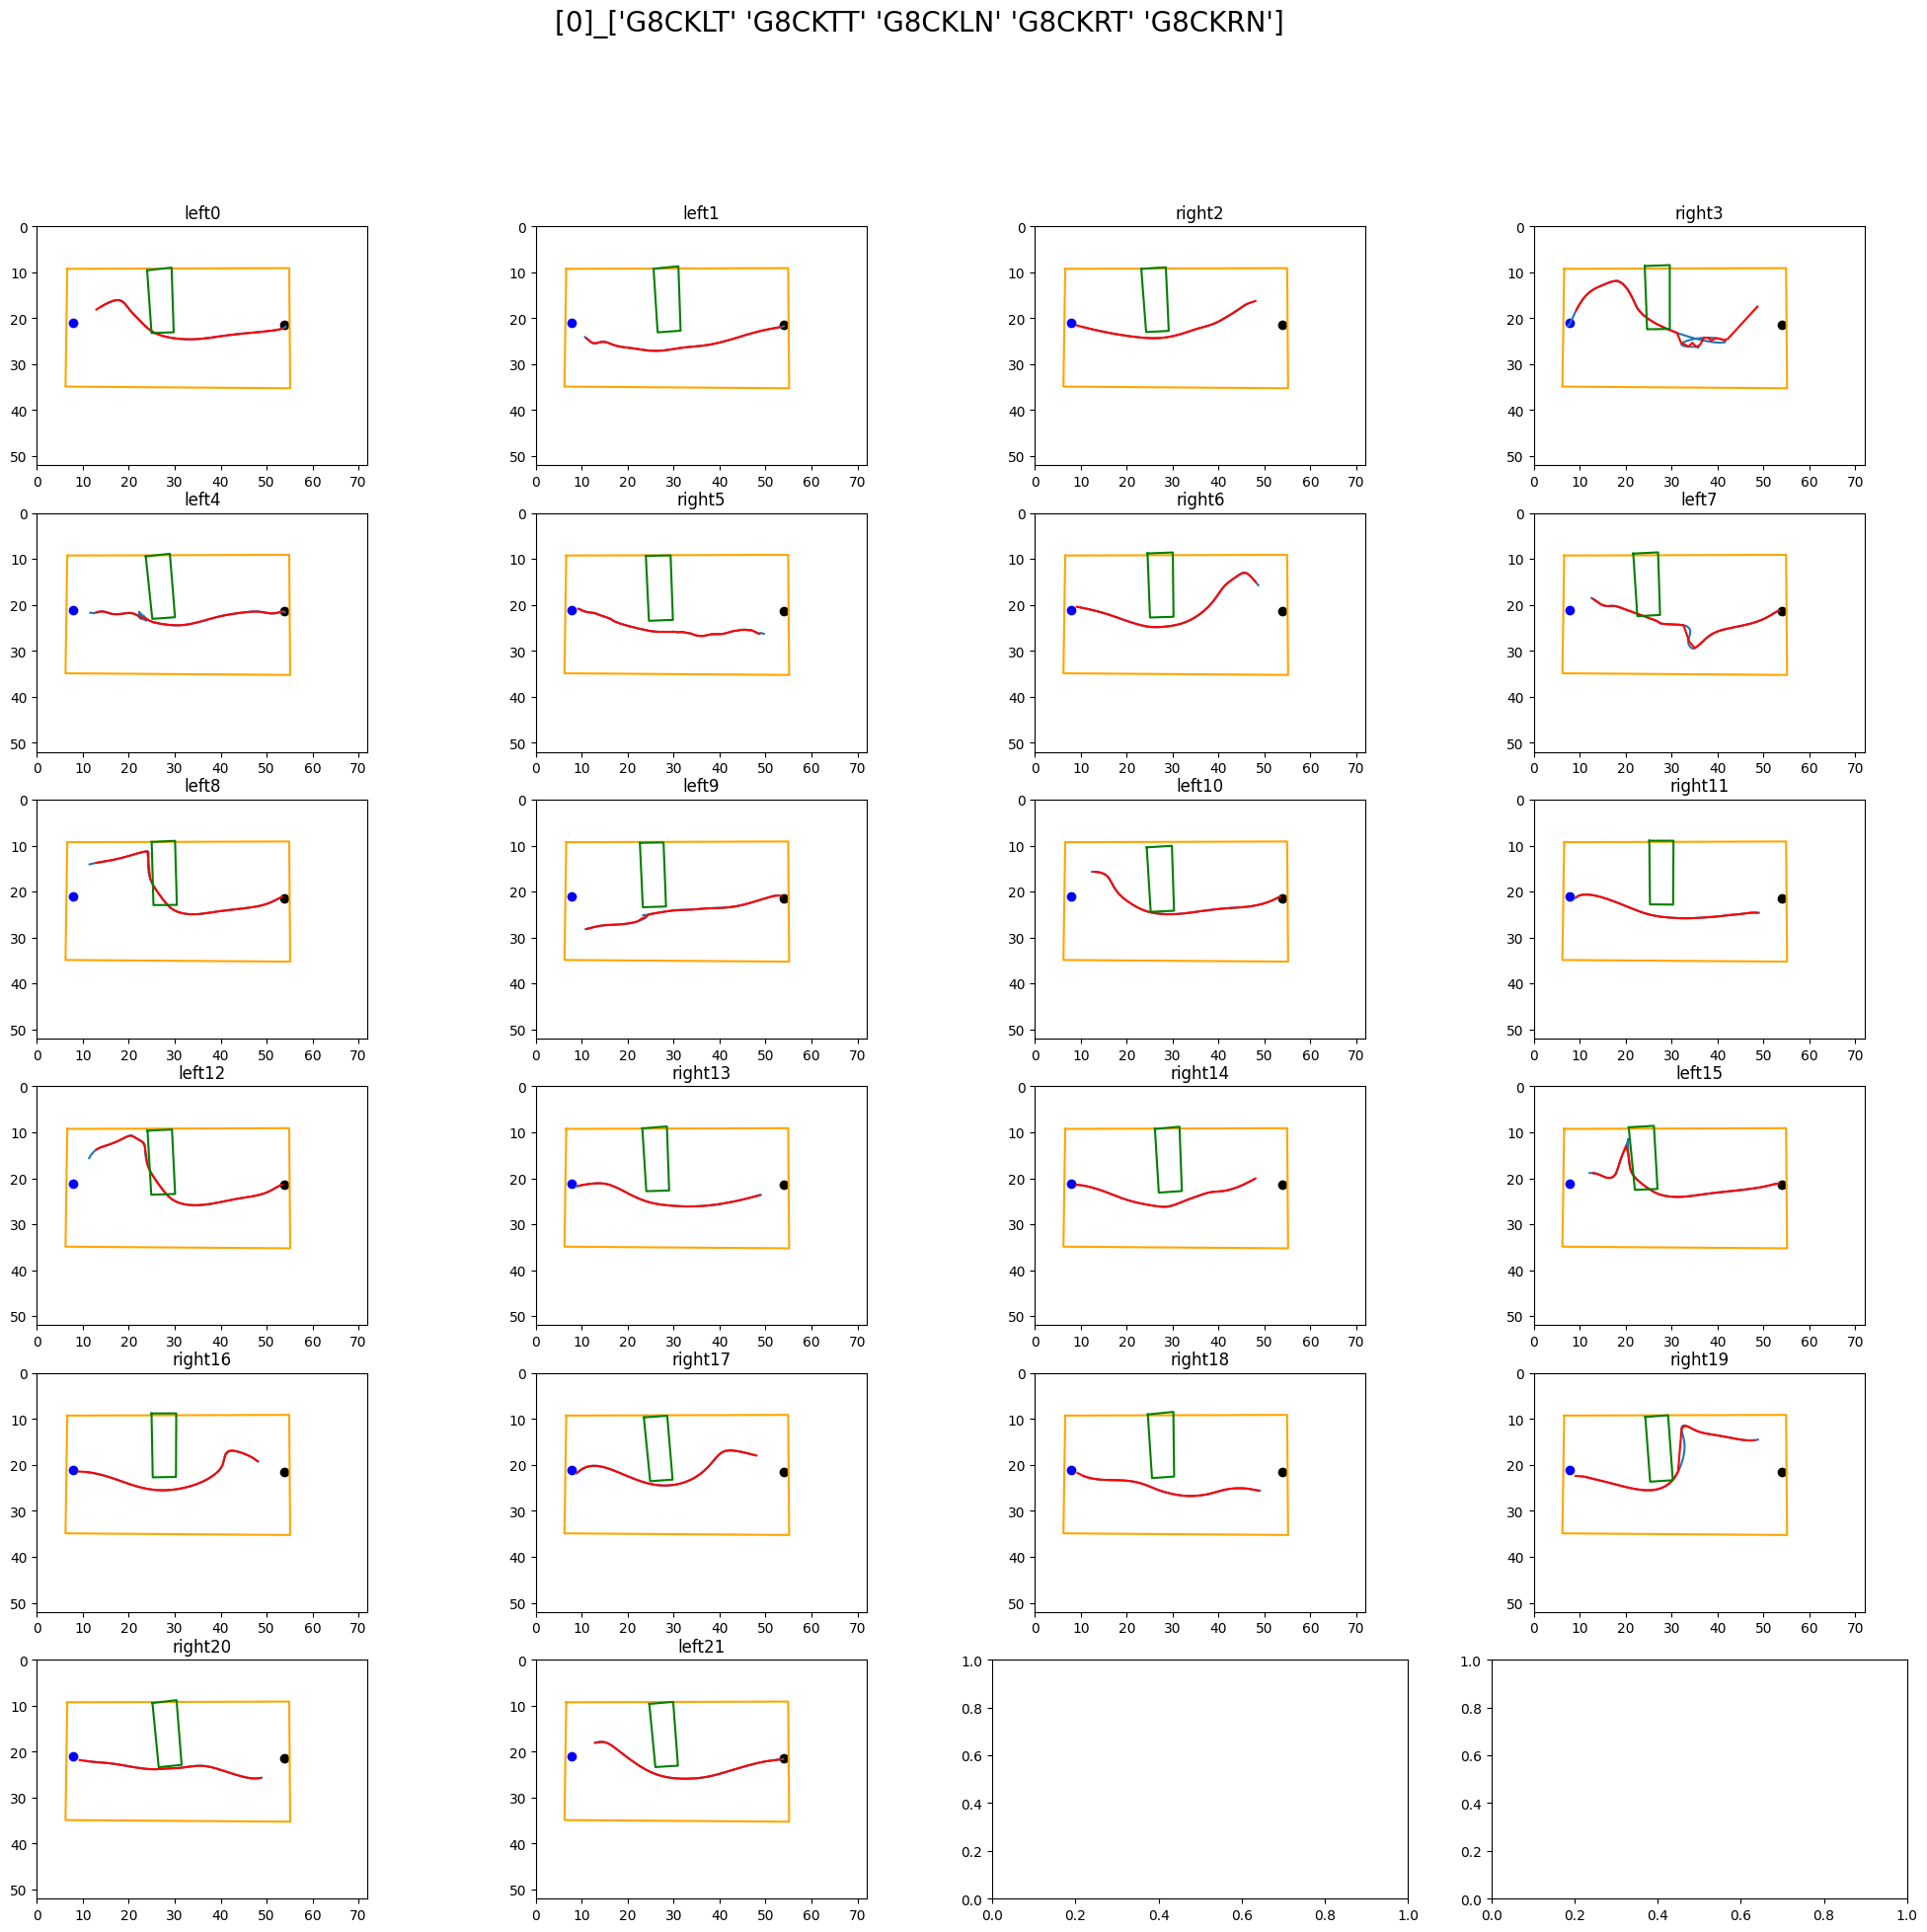

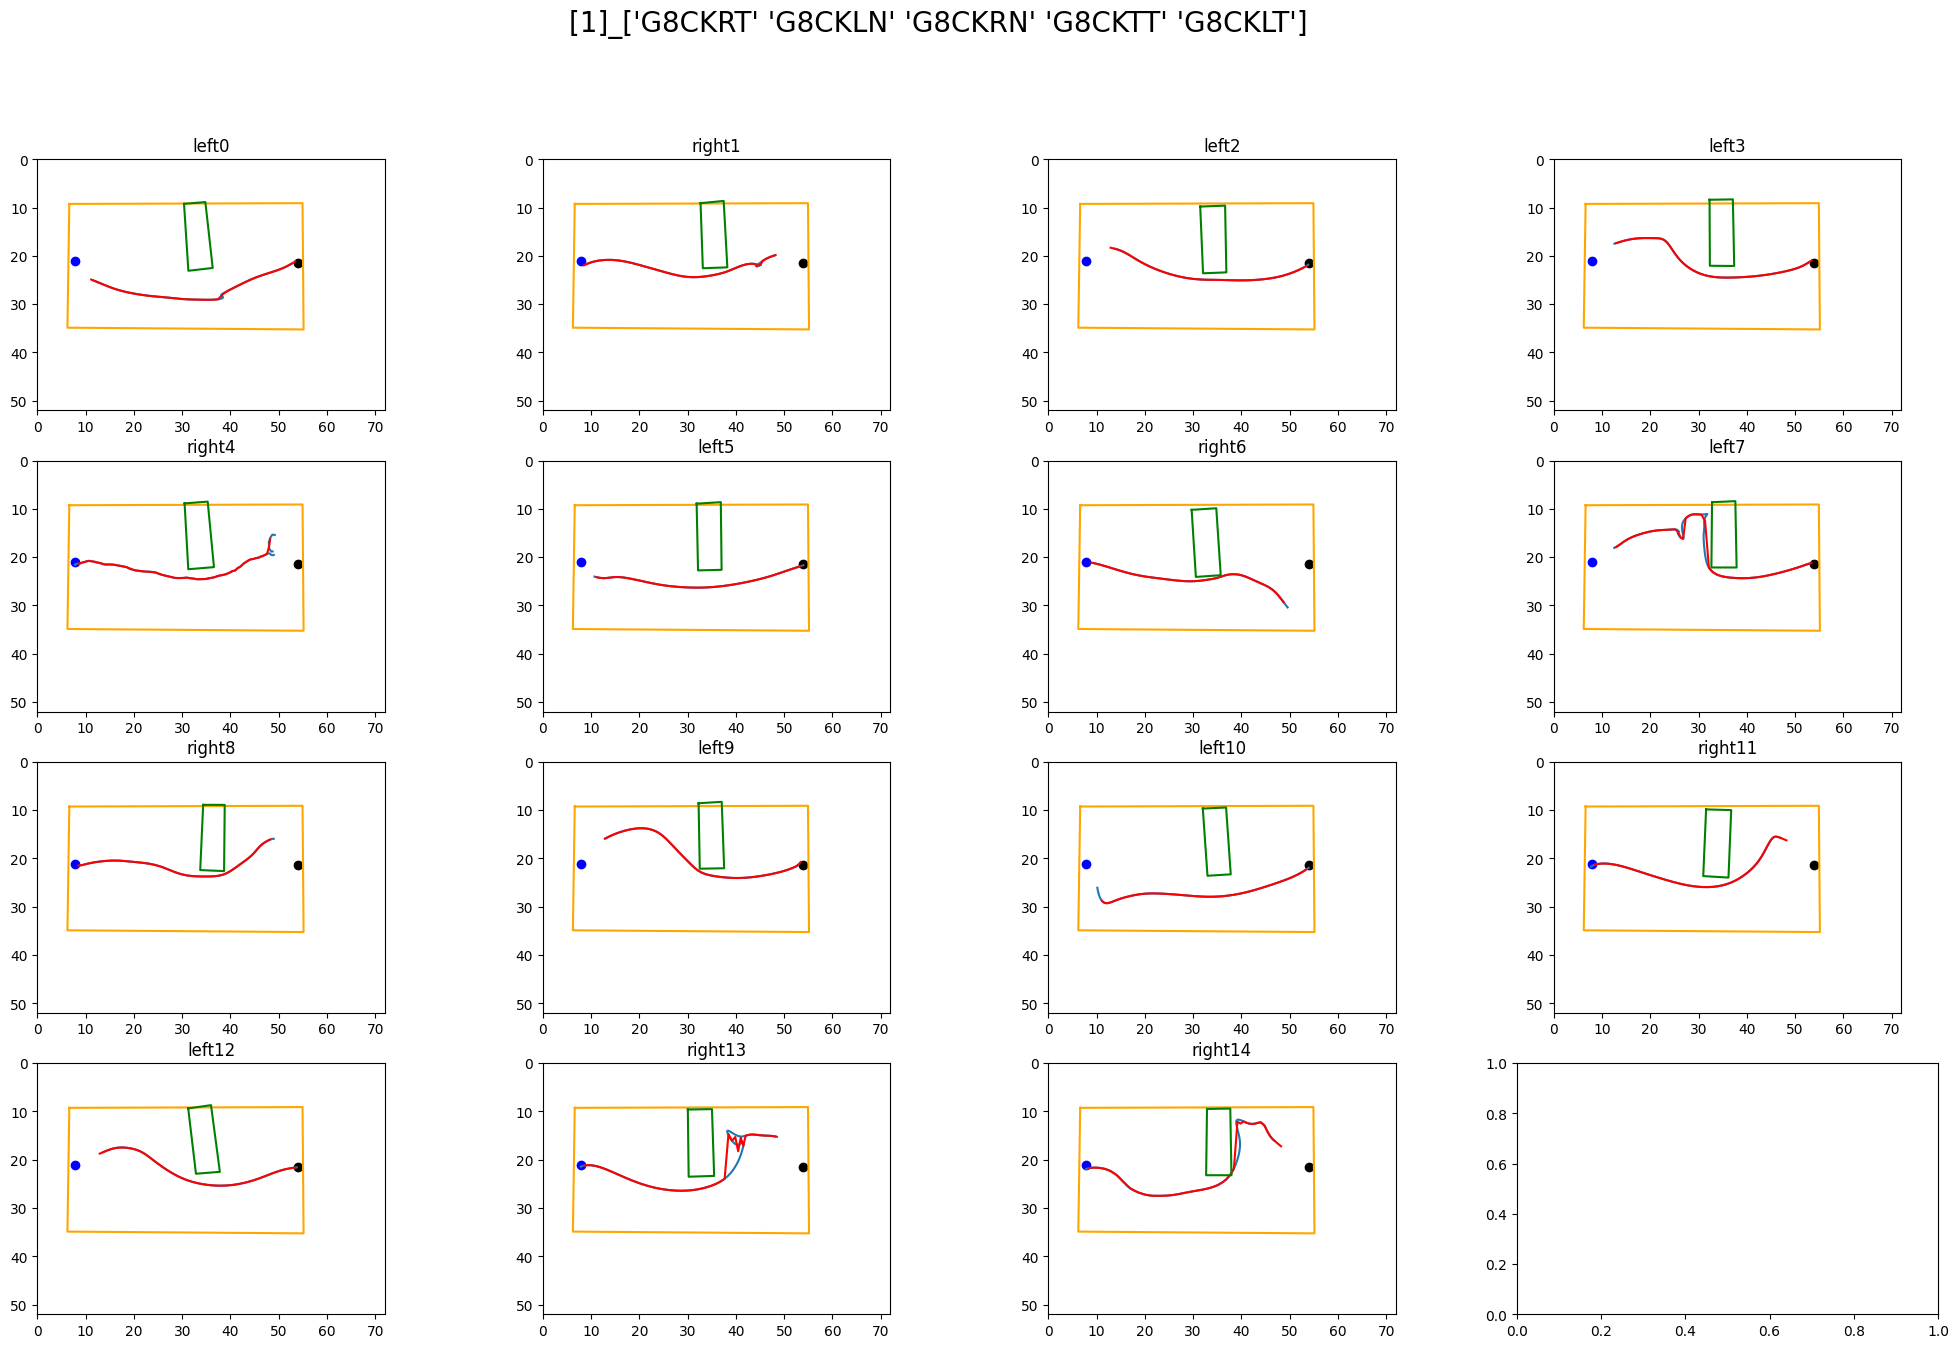

In [10]:
for cluster_num,cluster in enumerate(interp_df['obstacle_cluster'].unique()):
    #fig, ax = plt.subplots(,5, figsize=(25,21),dpi = 50)
    x = interp_df.loc[interp_df['obstacle_cluster']==cluster]
    x = x.reset_index()
    y = nearestX_roundup(len(x),4)
    fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(x)),dpi = 100)
    fig.suptitle(str(x['obstacle_cluster'].unique()) + '_' +str(x['animal'].unique()) , size = 20)
    for ind,row in x.iterrows():
        plt.subplot(int((y/4)),4,ind+1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_title(str(row['odd'])+str(ind))
        plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'])
        plt.plot(row['mean_interp_ts_nose_x_cm'],row['interp_ts_nose_y_cm'],'r')
        plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')
        plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
        #sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = row['obstacle_intersect_nose_x'], palette ='magma',legend=False)    
        #plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
        #plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
        #plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
        #plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
        #plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
        plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
        plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
        plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
plot_consective_trials()

In [383]:
df['mean_interp_ts_nose_y_cm'].isnull().sum()

0

In [384]:
df['mean_interp_ts_nose_y_cm']

0       [24.74558186736711, 24.822061532380186, 24.915...
1       [24.829744179438276, 24.870757697301773, 24.91...
2       [17.345791485123073, 17.368285326545962, 17.39...
3       [25.374360596087406, 25.427639804123896, 25.49...
4       [18.182644566939086, 18.075931689766747, 17.87...
                              ...                        
4571    [17.741761683875172, 17.69784415938655, 17.676...
4572    [21.66792543742457, 22.590551324738197, 24.010...
4573    [24.829744179438276, 24.870757697301773, 24.91...
4574    [18.182644566939086, 18.075931689766747, 17.87...
4575    [23.90168056556295, 24.056265930905806, 24.256...
Name: mean_interp_ts_nose_y_cm, Length: 4574, dtype: object

In [369]:

"""calculate the nose x interp
interp nose x is interpolation across the same time basis of 50 bins"""
fake_time = np.linspace(0,1,50)
for ind, row in self.df.iterrows():
    xT = np.linspace(0,1,len(row['ts_nose_x_cm']))
    intx = interp1d(xT, row['ts_nose_x_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
    self.df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)
    
"""get the average of nose x given the same start, obstalce and direction"""
for direction, direction_frame in self.df.groupby(['odd']):
    for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
        for start, start_frame in cluster_frame.groupby(['start']):
            array = np.zeros([len(start_frame), 50])
            count = 0
            for ind,row in start_frame.iterrows():
                array[count,:] = row['interp_ts_nose_x_cm']
                count += 1
            mean_trace = np.nanmean(array,axis = 0)
            x = self.df.loc[(self.df['obstacle_cluster'] ==cluster) & (self.df['start']==start)&(self.df['odd'] ==direction)]
            for ind,row in x.iterrows():
                self.df.at[ind,'mean_interp_ts_nose_x_cm']= mean_trace.astype(object)
            self.df = self.df[self.df['mean_interp_ts_nose_x_cm'].notna()]

"""Calculate interp y which is interpolation of nose_x vs nose_y then ploted against the mean_interp_noseX """
for ind,row in self.df.iterrows():
    
    interp = interp1d(row['ts_nose_x_cm'].astype(float), row['ts_nose_y_cm'].astype(float) ,bounds_error=False, fill_value="extrapolate")
    interp_y = interp(row['mean_interp_ts_nose_x_cm'].astype(float))
    interp_y = interpolate_array(interp_y)
    self.df.at[ind,'interp_ts_nose_y_cm'] = interp_y.astype(object)

for direction, direction_frame in self.df.groupby(['odd']):
    for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
        for start, start_frame in cluster_frame.groupby(['start']):
            array = np.zeros([len(start_frame), 50])
            count = 0
            for ind,row in start_frame.iterrows():
                array[count,:] = row['interp_ts_nose_y_cm']
                count += 1
            mean_trace = np.nanmean(array,axis=0)
            median_trace = np.nanmedian(array,axis = 0)
            x = self.df.loc[(self.df['obstacle_cluster'] ==cluster) & (self.df['start']==start)&(self.df['odd'] ==direction)]
            for ind,row in x.iterrows():
                if cluster in [2,3]:
                    self.df.at[ind,'mean_interp_ts_nose_y_cm']= median_trace.astype(object)
                else:
                    self.df.at[ind,'mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
    

array([47.2308539 , 47.02362271, 46.64064704, 46.14634485, 45.58027219,
       44.97270864, 44.33856013, 43.67516821, 42.97167741, 42.22877398,
       41.45313267, 40.65113666, 39.82781697, 38.99393175, 38.15498314,
       37.30735924, 36.46023875, 35.60640173, 34.74901363, 33.89151797,
       33.04349201, 32.20322421, 31.35910979, 30.50636114, 29.64155618,
       28.76663558, 27.86775898, 26.95007589, 26.01540598, 25.03728159,
       24.00733783, 22.94132694, 21.83639256, 20.70622452, 19.56140388,
       18.41130754, 17.27695433, 16.17287846, 15.10299114, 14.068831  ,
       13.09903632, 12.19551748, 11.37604385, 10.65332123, 10.04121534,
        9.54920147,  9.19687473,  8.98060701,  8.86771793,  8.82022444])

In [346]:
interp = interp1d(row['ts_nose_x_cm'].astype(float), row['ts_nose_y_cm'].astype(float) ,bounds_error=False, fill_value="extrapolate")
interpolate_array(interp(row['mean_interp_ts_nose_x_cm'].astype(float)))


array([22.02954764, 22.04800492, 22.07906741, 22.11615058, 22.16462224,
       22.24161476, 22.35377644, 22.50089854, 22.66578437, 22.81888925,
       22.93174489, 22.98107286, 22.97557569, 22.93702301, 22.89894734,
       22.91841961, 26.09090463, 30.85293754, 30.42590725, 30.26580798,
       30.21437723, 30.19963541, 30.18968561, 30.15823612, 30.05966684,
       29.87946336, 29.65976457, 29.4361271 , 29.21123798, 28.99734132,
       28.79201165, 28.58786372, 28.37050926, 28.12289526, 27.84963183,
       27.54935783, 27.22335647, 26.86681855, 26.46370763, 26.02337554,
       25.55600541, 25.08816312, 24.63067447, 24.17309827, 23.73584402,
       23.36068625, 23.08971581, 22.93931659, 22.87331289, 22.87331289])

In [339]:
len(row['ts_nose_y_cm'])

196

In [318]:
row['mean_interp_ts_nose_x_cm']

array([48.83511684877562, 48.57885070406783, 48.14757020914758,
       47.632696872541906, 47.07490128284056, 46.484049670016965,
       45.85600127033971, 45.19521560034681, 44.52000061570619,
       43.8369807004145, 43.14099626034644, 42.42688307916852,
       41.70644283420612, 41.01094091000616, 40.34842495964459,
       39.673012356334446, 38.97222143336797, 38.24247371153704,
       37.50076985720303, 36.70343601111739, 35.86280218542682,
       34.98271015632225, 34.0426384192012, 33.03414001410708,
       32.008239856860136, 30.96055228570283, 29.909710337805297,
       28.845831694869595, 27.724690993755786, 26.580037678138755,
       25.428750676393406, 24.279435360547776, 23.11960424400906,
       21.935229832763767, 20.74260870141438, 19.540063831226227,
       18.32750280107657, 17.126443730365764, 15.944829570068078,
       14.814140377642666, 13.745944889160544, 12.757171715947571,
       11.867664805944498, 11.090672475784116, 10.451424861389064,
       9.9659417035504

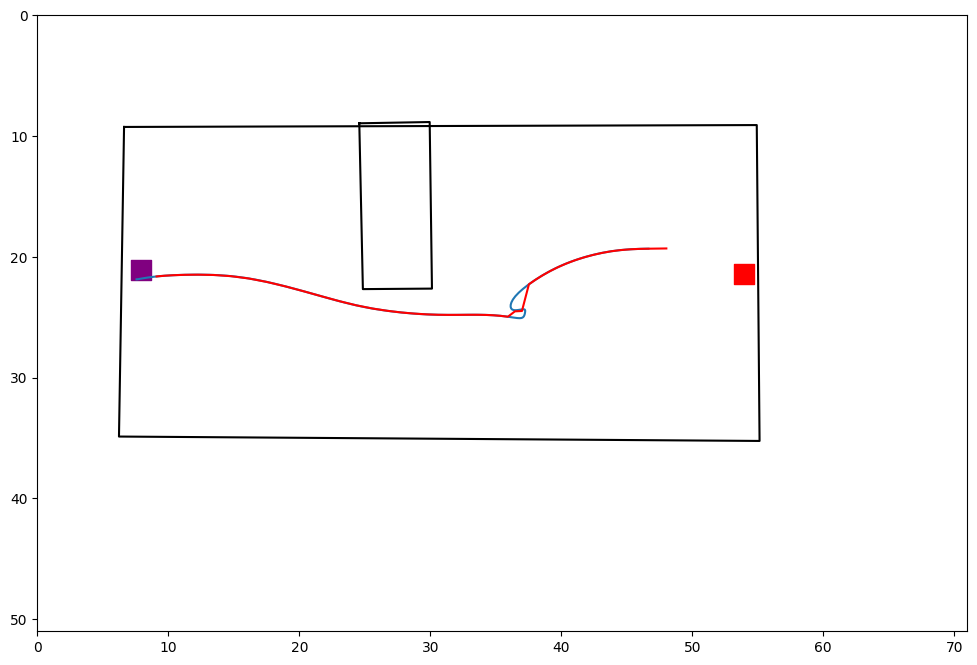

In [57]:
test = df.sample(1)
interp = interp1d(test['ts_nose_x_cm'].item(), test['ts_nose_y_cm'].item(), bounds_error=False,fill_value= 'extrapolate')
fig, ax = plt.subplots(figsize=(12, 8))
plot_single_trial(test,ax,test['obstacle_cluster'].item())
ax.plot(test['mean_interp_ts_nose_x_cm'].item(),interp(test['mean_interp_ts_nose_x_cm'].item()),'r')
   

In [ ]:
""" interpolate nose x and nose y"""
"""calculate interp traces"""
for ind, row in self.df.iterrows():

    intx = interp1d(row['ts_nose_x_cm'], row['ts_nose_7_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
   
    self.df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)
    self.df.at[ind,'interp_ts_nose_y_cm'] = inty.astype(object)

In [186]:
def speed(df):
    time = float(1/60)
    for ind, row in df.iterrows():
        speed = calculate_speed(row['ts_nose_x_cm'],row['ts_nose_y_cm'],time)
        df.at[ind,'speed'] = speed.astype(object)
        

In [187]:
speed(df)

In [199]:
for ind, row in df.iterrows():
    df.at[ind,'len_speed'] = len(row['speed'])
    df.at[ind,'std_speed'] = np.nanstd(row['speed'])
    df.at[ind,'mean_speed'] = np.nanmean(row['speed'])
    df.at[ind,'median_speed'] = np.nanmedian(row['speed'])

In [195]:
np.nanstd(row['speed'])

11.89551305622593

(array([2.541e+03, 1.364e+03, 3.610e+02, 1.570e+02, 7.000e+01, 3.900e+01,
        1.900e+01, 1.400e+01, 9.000e+00, 2.000e+00]),
 array([ 41. ,  80.7, 120.4, 160.1, 199.8, 239.5, 279.2, 318.9, 358.6,
        398.3, 438. ]),
 <BarContainer object of 10 artists>)

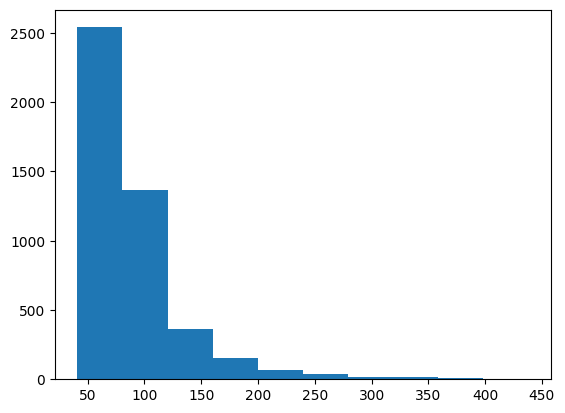

In [191]:
plt.hist(df['len_speed'])

(array([  58.,  151.,  298.,  485.,  793., 1139.,  978.,  507.,  140.,
          27.]),
 array([ 0.46299277,  7.22733554, 13.9916783 , 20.75602106, 27.52036382,
        34.28470658, 41.04904934, 47.8133921 , 54.57773487, 61.34207763,
        68.10642039]),
 <BarContainer object of 10 artists>)

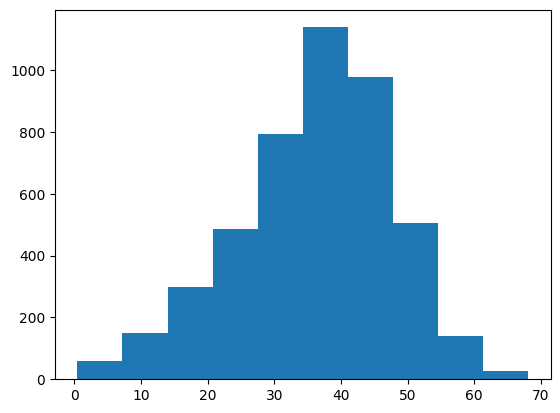

In [200]:
plt.hist(df['median_speed'])

In [202]:
x = interpolate_array(test.ts_nose_x_cm.item())
y = interpolate_array(test.ts_nose_y_cm.item())
time = float(1/60)
speed = calculate_speed(x,y,time)

In [203]:
speed = gaussian_filter1d(speed,1)

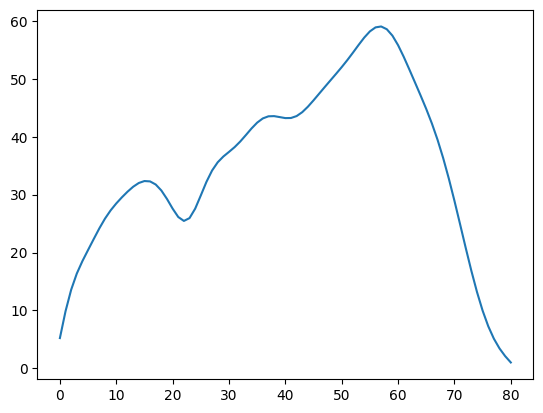

In [281]:
plt.plot(range(len(speed)),speed)

(array([ 3.,  3.,  3.,  2.,  2., 12., 21., 14.,  5., 13.]),
 array([ 1.48301592,  6.25868265, 11.03434938, 15.81001611, 20.58568283,
        25.36134956, 30.13701629, 34.91268302, 39.68834975, 44.46401647,
        49.2396832 ]),
 <BarContainer object of 10 artists>)

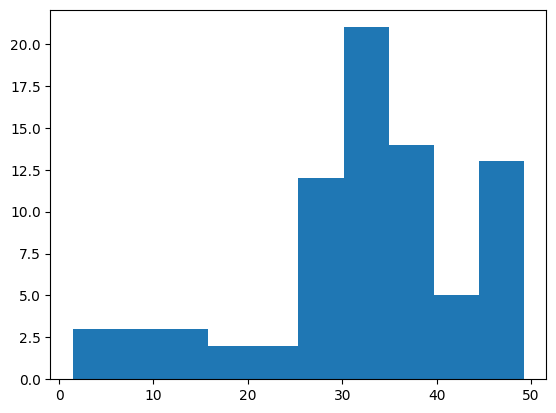

In [86]:
plt.hist(speed)

In [210]:
normalizedData = speed/np.linalg.norm(speed)
normalizedData = np.append(normalizedData,normalizedData[-1])

82

In [212]:
normalizedData = speed/np.linalg.norm(speed)
normalizedData = np.append(normalizedData,normalizedData[-1])

In [213]:
normalizedData

array([0.02085881, 0.02860394, 0.03852758, 0.04702656, 0.05386546,
       0.05978015, 0.06531968, 0.07058734, 0.07540412, 0.0796106 ,
       0.08322823, 0.08639684, 0.08920742, 0.09159445, 0.09335039,
       0.09420932, 0.09392502, 0.09232954, 0.08941455, 0.0854618 ,
       0.08117315, 0.07766827, 0.07619792, 0.07758357, 0.08172505,
       0.08761325, 0.09386982, 0.09938873, 0.10369232, 0.10691886,
       0.10956371, 0.11215332, 0.11500024, 0.11811061, 0.12123124,
       0.1239794 , 0.1260011 , 0.12711424, 0.12739491, 0.12717353,
       0.12693567, 0.12716282, 0.12817814, 0.13006242, 0.13267488,
       0.13575822, 0.13906221, 0.1424222 , 0.14577537, 0.14913957,
       0.15257961, 0.15616101, 0.15988812, 0.16364393, 0.16716165,
       0.17004755, 0.17185218, 0.17217556, 0.17077909, 0.16766462,
       0.16308164, 0.15744744, 0.1512064 , 0.14468406, 0.13799245,
       0.131022  , 0.12351903, 0.11521001, 0.10591791, 0.09563057,
       0.08451278, 0.07287818, 0.06114317, 0.04977554, 0.03923

In [237]:
speed

array([ 5.20618566,  9.84324354, 13.56271914, 16.35947755, 18.52304   ,
       20.43503414, 22.32278837, 24.17430778, 25.8558743 , 27.28169158,
       28.47959063, 29.53844615, 30.51118843, 31.36770376, 32.01709703,
       32.35444617, 32.29001077, 31.75509787, 30.72173046, 29.25590047,
       27.58602669, 26.13797642, 25.45724762, 25.94736865, 27.57437598,
       29.86305365, 32.20784075, 34.16982763, 35.59713211, 36.59277834,
       37.39050285, 38.21622247, 39.19075881, 40.30385103, 41.44386681,
       42.45119779, 43.17780289, 43.54475256, 43.57785272, 43.409208  ,
       43.23587535, 43.25279464, 43.58707695, 44.26155882, 45.20544107,
       46.30525862, 47.46135579, 48.61709729, 49.7568456 , 50.89160099,
       52.05070089, 53.26833016, 54.55838181, 55.88736269, 57.15940663,
       58.22756001, 58.9188232 , 59.07513345, 58.59899428, 57.48831343,
       55.84379906, 53.83563114, 51.64384297, 49.39807302, 47.13794329,
       44.81020285, 42.30332809, 39.50148167, 36.33232687, 32.79

In [223]:
speed = np.append(speed,speed[-1])

In [250]:
color_list = []

for val in speed:
    if 0 <= val <= 20:
        color_list.append('b')
    if 20 <= val <= 40:
        color_list.append('g')
    if 40 <= val <= 60:
        color_list.append('r')
    if val > 60:
        color_list.append('c')
        

In [295]:
len(color_list)

82

In [296]:
points.shape

(82, 1, 2)

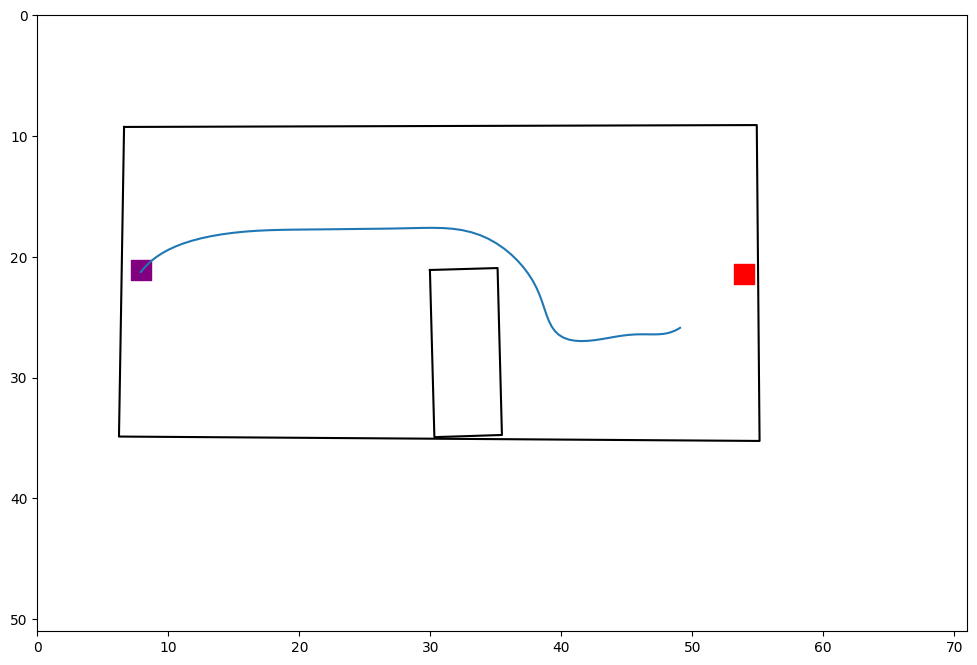

In [294]:
#test = session.df.sample(1)
#angle_to_edges(test)
#get_angle_to_ports(test)

x = interpolate_array(test.ts_nose_x_cm.item()).tolist()
y = interpolate_array(test.ts_nose_y_cm.item()).tolist()
time = float(1/60)
speed = calculate_speed(x,y,time)
speed = np.append(speed,speed[-1])
color_list = []

for val in speed:
    if 0 <= val <= 20:
        color_list.append('b')
    if 20 <= val <= 40:
        color_list.append('g')
    if 40 <= val <= 60:
        color_list.append('r')
    if val > 60:
        color_list.append('c')
points = np.array([x, y]).T.reshape(-1, 1, 2)
fig, ax = plt.subplots(figsize=(12, 8))
plot_single_trial(test,ax,test['obstacle_cluster'].item())
colored_lines = LineCollection(points,colors = color_list, linewidths=(2,))
ax.add_collection(colored_lines)






In [282]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def threshold_plot(ax, x, y, threshv, color, overcolor):
    """
    Helper function to plot points above a threshold in a different color

    Parameters
    ----------
    ax : Axes
        Axes to plot to
    x, y : array
        The x and y values

    threshv : float
        Plot using overcolor above this value

    color : color
        The color to use for the lower values

    overcolor: color
        The color to use for values over threshv

    """
    # Create a colormap for red, green and blue and a norm to color
    # f' < -0.5 red, f' > 0.5 blue, and the rest green
    cmap = ListedColormap([color, overcolor])
    norm = BoundaryNorm([np.min(y), threshv, np.max(y)], cmap.N)

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be numlines x points per line x 2 (x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the line collection object, setting the colormapping parameters.
    # Have to set the actual values used for colormapping separately.
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)

    ax.add_collection(lc)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y)*1.1, np.max(y)*1.1)
    return lc,points

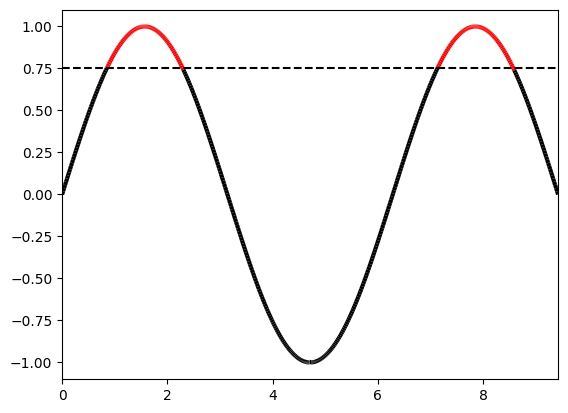

In [283]:
fig, ax = plt.subplots()

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)

lc,points = threshold_plot(ax, x, y, .75, 'k', 'r')
ax.axhline(.75, color='k', ls='--')
lc.set_linewidth(3)

In [286]:
points

array([[[49.06802754, 25.87795993]],

       [[48.99563992, 25.92580367]],

       [[48.85584137, 26.01165296]],

       [[48.65661298, 26.11844499]],

       [[48.40620979, 26.22633661]],

       [[48.11130207, 26.31763738]],

       [[47.77665357, 26.38094438]],

       [[47.4060285 , 26.41343491]],

       [[47.00319196, 26.42086925]],

       [[46.57229538, 26.41540463]],

       [[46.11761349, 26.41196966]],

       [[45.64311202, 26.42423024]],

       [[45.152196  , 26.46121768]],

       [[44.64774255, 26.52539803]],

       [[44.13224728, 26.61245721]],

       [[43.60810579, 26.71257796]],

       [[43.07822354, 26.81260503]],

       [[42.54693009, 26.89834196]],

       [[42.02085831, 26.95627104]],

       [[41.50914941, 26.97436887]],

       [[41.02262113, 26.94208305]],

       [[40.57216054, 26.85004471]],

       [[40.16695546, 26.6900919 ]],

       [[39.81304042, 26.45607483]],

       [[39.51229507, 26.14531679]],

       [[39.26166095, 25.76010281]],

       [[39.

In [284]:
points

array([[[ 0.00000000e+00,  0.00000000e+00]],

       [[ 1.88873306e-02,  1.88862077e-02]],

       [[ 3.77746612e-02,  3.77656782e-02]],

       [[ 5.66619917e-02,  5.66316770e-02]],

       [[ 7.55493223e-02,  7.54774740e-02]],

       [[ 9.44366529e-02,  9.42963467e-02]],

       [[ 1.13323983e-01,  1.13081582e-01]],

       [[ 1.32211314e-01,  1.31826479e-01]],

       [[ 1.51098645e-01,  1.50524350e-01]],

       [[ 1.69985975e-01,  1.69168526e-01]],

       [[ 1.88873306e-01,  1.87752357e-01]],

       [[ 2.07760636e-01,  2.06269212e-01]],

       [[ 2.26647967e-01,  2.24712487e-01]],

       [[ 2.45535298e-01,  2.43075602e-01]],

       [[ 2.64422628e-01,  2.61352007e-01]],

       [[ 2.83309959e-01,  2.79535183e-01]],

       [[ 3.02197289e-01,  2.97618642e-01]],

       [[ 3.21084620e-01,  3.15595935e-01]],

       [[ 3.39971950e-01,  3.33460648e-01]],

       [[ 3.58859281e-01,  3.51206409e-01]],

       [[ 3.77746612e-01,  3.68826887e-01]],

       [[ 3.96633942e-01,  3.86315

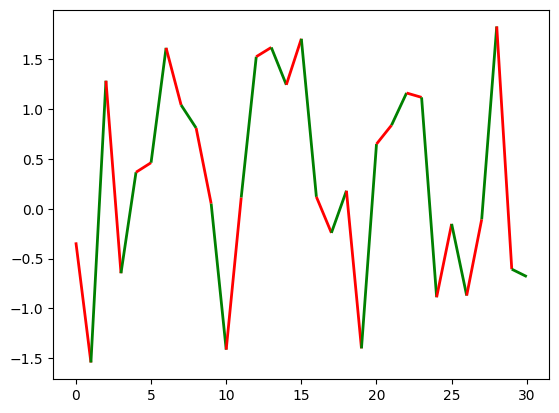

In [260]:
# construct some data
n = 30
x = np.arange(n+1)           # resampledTime
y = np.random.randn(n+1)     # modulusOfZeroNormalized
annotation = [True, False] * 15

# set up colors 
c = ['r' if a else 'g' for a in annotation]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(2,))

# plot data
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

In [261]:
lines

[((0, -0.3375471985324109), (1, -1.5428763703457333)),
 ((1, -1.5428763703457333), (2, 1.2837783935507086)),
 ((2, 1.2837783935507086), (3, -0.6475168645142688)),
 ((3, -0.6475168645142688), (4, 0.36570901048724763)),
 ((4, 0.36570901048724763), (5, 0.4615589925509675)),
 ((5, 0.4615589925509675), (6, 1.6139747113562746)),
 ((6, 1.6139747113562746), (7, 1.0400425640888782)),
 ((7, 1.0400425640888782), (8, 0.8091872353234368)),
 ((8, 0.8091872353234368), (9, 0.05032237802168286)),
 ((9, 0.05032237802168286), (10, -1.413913981524686)),
 ((10, -1.413913981524686), (11, 0.11324741975852563)),
 ((11, 0.11324741975852563), (12, 1.5251283405667388)),
 ((12, 1.5251283405667388), (13, 1.6179705962876527)),
 ((13, 1.6179705962876527), (14, 1.2431046293792316)),
 ((14, 1.2431046293792316), (15, 1.704955540763375)),
 ((15, 1.704955540763375), (16, 0.11899591329592157)),
 ((16, 0.11899591329592157), (17, -0.242513083265334)),
 ((17, -0.242513083265334), (18, 0.18006736978457613)),
 ((18, 0.18006736

In [262]:
points[0]

array([[49.06802754, 25.87795993]])

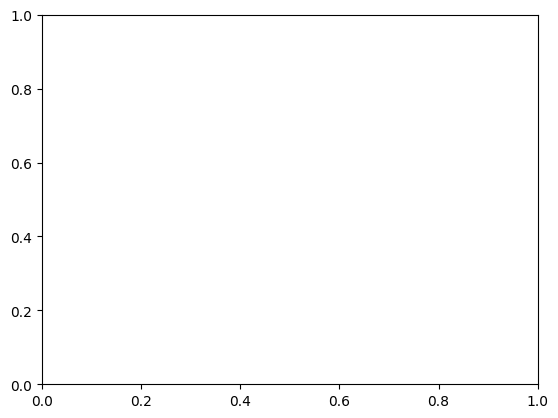

In [258]:
fig, ax = plt.subplots(1)
colored_lines = LineCollection(points,colors = color_list, linewidths=(2,))
ax.add_collection(colored_lines)


In [216]:
x = interpolate_array(test.ts_nose_x_cm.item())
y = interpolate_array(test.ts_nose_y_cm.item())
time = float(1/60)
speed = calculate_speed(x,y,time)
points = np.array([x, y]).T.reshape(-1, 1, 2)

In [183]:
points.shape

(82, 1, 2)

In [184]:
points[1]

array([[48.99563992, 25.92580367]])

In [221]:
speed

array([ 5.20618566,  9.84324354, 13.56271914, 16.35947755, 18.52304   ,
       20.43503414, 22.32278837, 24.17430778, 25.8558743 , 27.28169158,
       28.47959063, 29.53844615, 30.51118843, 31.36770376, 32.01709703,
       32.35444617, 32.29001077, 31.75509787, 30.72173046, 29.25590047,
       27.58602669, 26.13797642, 25.45724762, 25.94736865, 27.57437598,
       29.86305365, 32.20784075, 34.16982763, 35.59713211, 36.59277834,
       37.39050285, 38.21622247, 39.19075881, 40.30385103, 41.44386681,
       42.45119779, 43.17780289, 43.54475256, 43.57785272, 43.409208  ,
       43.23587535, 43.25279464, 43.58707695, 44.26155882, 45.20544107,
       46.30525862, 47.46135579, 48.61709729, 49.7568456 , 50.89160099,
       52.05070089, 53.26833016, 54.55838181, 55.88736269, 57.15940663,
       58.22756001, 58.9188232 , 59.07513345, 58.59899428, 57.48831343,
       55.84379906, 53.83563114, 51.64384297, 49.39807302, 47.13794329,
       44.81020285, 42.30332809, 39.50148167, 36.33232687, 32.79

In [267]:
points

array([[[49.06802754, 25.87795993]],

       [[48.99563992, 25.92580367]],

       [[48.85584137, 26.01165296]],

       [[48.65661298, 26.11844499]],

       [[48.40620979, 26.22633661]],

       [[48.11130207, 26.31763738]],

       [[47.77665357, 26.38094438]],

       [[47.4060285 , 26.41343491]],

       [[47.00319196, 26.42086925]],

       [[46.57229538, 26.41540463]],

       [[46.11761349, 26.41196966]],

       [[45.64311202, 26.42423024]],

       [[45.152196  , 26.46121768]],

       [[44.64774255, 26.52539803]],

       [[44.13224728, 26.61245721]],

       [[43.60810579, 26.71257796]],

       [[43.07822354, 26.81260503]],

       [[42.54693009, 26.89834196]],

       [[42.02085831, 26.95627104]],

       [[41.50914941, 26.97436887]],

       [[41.02262113, 26.94208305]],

       [[40.57216054, 26.85004471]],

       [[40.16695546, 26.6900919 ]],

       [[39.81304042, 26.45607483]],

       [[39.51229507, 26.14531679]],

       [[39.26166095, 25.76010281]],

       [[39.

In [136]:
pd.unique(test[['leftportT_x_cm','leftportT_y_cm']].values.ravel('K'))

array([ 7.87607541, 21.09711462])